In [2]:
import os
import json
import numpy as np
import copy
from pathlib import Path
from PIL import Image, ExifTags
from PIL import ImageDraw
from abc import ABCMeta, abstractmethod
from copy import deepcopy
#from pycocotools.coco import COCO
#from torchvision import transforms
import pickle
from shutil import copyfile
import os
import json

ann_filepath = os.path.join("./" , 'annotations.json')
with open(ann_filepath, 'r') as f:
    ds = json.load(f)

ds['annotations']


[{'id': 2,
  'image_id': 2,
  'category_id': 1,
  'segmentation': [],
  'area': 97149.82975961648,
  'bbox': [50.14188772362739,
   238.5946649316851,
   521.9494139420111,
   186.12882238126218],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 3,
  'category_id': 1,
  'segmentation': [],
  'area': 94582.50693113412,
  'bbox': [83.02702702702703,
   215.2765126870527,
   508.15615615615616,
   186.12882238126218],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 4,
  'category_id': 1,
  'segmentation': [],
  'area': 57642.706456932036,
  'bbox': [241.45738451528953,
   39.66813079551001,
   139.59661678594665,
   412.92337725719864],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 5,
  'category_id': 0,
  'segmentation': [],
  'area': 376358.9217433855,
  'bbox': [3.747560182173064,
   44.554326610279766,
   632.5048796356539,
   595.0292778139232],
  'iscrowd': 0},
 {'id': 6,
  'image_id': 5,
  'category_id': 0,
  'segmentation': [],
  'area': 90003.60299343582,
  'bbox': [0.0, 0.0, 214.86011711125568, 

In [3]:
def get_many_annotations(dsj):
    """ 
       returns dict with list with annotations groupped by image_id
       image_id is a key
    """
    result = {}
    for a in dsj['annotations']:
        if a['image_id'] in result:
            result[a['image_id']].append(a)
        else:
            result[a['image_id']] = [a]
    return result

def save_json_data(dsj, path):
    raw_data = json.dumps(dsj)
    with open(path, "w") as f:
        f.write(raw_data)
    return

def load_taco( dataset_dir, subset, class_ids=None,
              class_map=None, return_taco=True, auto_download=False):
    """Load a subset of the TACO dataset.
    dataset_dir: The root directory of the TACO dataset.
    subset: which subset to load (train, val, test)
    class_ids: If provided, only loads images that have the given classes.
    class_map: Dictionary used to assign original classes to new class system
    return_coco: If True, returns the COCO object.
    auto_download: Automatically download and unzip MS-COCO images and annotations
    """

    # TODO: Once we got the server running
    # if auto_download is True:
    #     self.auto_download(dataset_dir, subset, year)
    ann_filepath = os.path.join(dataset_dir , 'annotations.json')

    assert os.path.isfile(ann_filepath)

    # Load dataset
    dataset = json.load(open(ann_filepath, 'r'))

    taco_alla_coco = COCO()
    taco_alla_coco.dataset = dataset
    taco_alla_coco.createIndex()

    # Add images and classes except Background
    # Definitely not the most efficient way
    image_ids = []
    background_id = -1
    class_ids = sorted(taco_alla_coco.getCatIds())
    classes = []
    for i in class_ids:
        class_name = taco_alla_coco.loadCats(i)[0]["name"]
        classes.append(class_name)
        if class_name != 'Background':
            image_ids.extend(list(taco_alla_coco.getImgIds(catIds=i)))
        else:
            background_id = i
    image_ids = list(set(image_ids))
    print(classes)
    if background_id > -1:
        class_ids.remove(background_id)
    print('Number of images used:', len(image_ids))
    # Add images
    for i in image_ids:
        annotations=taco_alla_coco.loadAnns(taco_alla_coco.getAnnIds(
                imgIds=[i], catIds=class_ids, iscrowd=None))
        print("id/ path/ w/ h/ annotations", i,taco_alla_coco.imgs[i]['file_name'],
              taco_alla_coco.imgs[i]["width"], taco_alla_coco.imgs[i]["height"], annotations[0]['bbox'], len(annotations))

    return taco_alla_coco, dataset



ann_filepath = os.path.join("./" , 'annotations.json')
with open(ann_filepath, 'r') as f:
    ds = json.load(f)
im_files = {c['id']:c for c in ds['images']}
annotations = get_many_annotations(ds)

to_fix=["large/BTl_001823_0.jpg", # [     2.5078      1.5697      1.5365]
"large/unofficial_000510.jpg",   # [     1.5599]
"large/unofficial_000706.jpg",   # [     1.1803      2.2445]
"large/unofficial_001691.jpg",   # [     1.6587      3.1314]
"large/unofficial_002264.jpg",   # [     1.3307]
"large/unofficial_002549.jpg",   # [      1.135      2.1567]
"large/unofficial_002996.jpg",   # [     1.2487]
"large/unofficial_001832.jpg"]   # [     1.0941]

i = 0
# for img in im_files.keys():
#     if im_files[img]['file_name'] in to_fix:
#          for aa in annotations[img]:
#                 print(im_files[img]['file_name'], aa['bbox'])

# ann_filepath = os.path.join("./" , 'annotations_unofficial.json')
# with open(ann_filepath, 'r') as f:
#     ds = json.load(f)
# ds['images']

# im_files = {c['id']:c for c in ds['images']}
# annotations = get_many_annotations(ds)

# to_fix=["BTl_001823_0.jpg", # [     2.5078      1.5697      1.5365]
# "unofficial_000510.jpg",   # [     1.5599]
# "unofficial_000706.jpg",   # [     1.1803      2.2445]
# "unofficial_001691.jpg",   # [     1.6587      3.1314]
# "unofficial_002264.jpg",   # [     1.3307]
# "unofficial_002549.jpg",   # [      1.135      2.1567]
# "unofficial_002996.jpg",   # [     1.2487]
# "unofficial_001832.jpg" ]   # [     1.0941]

# for img in im_files.keys():
#     if im_files[img]['file_name'].replace("/", "_") in to_fix:
#          for aa in annotations[img]:
#                 print(im_files[img]['flickr_url'].replace("png", "jpeg"), im_files[img]['file_name'], aa['bbox'], im_files[img]['width'], im_files[img]['height'])

# print(im_files)

In [11]:
#taco, ds = load_taco("/media/pavel/11b20043-29ef-495b-a4d6-9e65e8a48f8b/srv/tmp/0/0litter/taco/taco/data", "batch_1")

def sampling_kfold_cross_val(model, X, Y, scoring, sampling_strategy, N=5):
    """k-fold cross validation with train data down sampling """
    num = len(Y) // N
    result = {}
    bal_accuracies = []
    for i in range(N):
        x_val = X[i * num : (i + 1) * num]
        y_val = Y[i * num : (i + 1) * num]
        x_train = np.concatenate([X[:i * num], X[(i + 1) * num:]], axis=0)
        y_train = np.concatenate([Y[:i * num], Y[(i + 1) * num:]], axis=0)
        x, y = sampling_strategy(X, Y)
        model.fit(x, y)
        preds = model.predict(x_val)
        add_scores(result, y_val, preds, scoring)
        bal_accuracies.append(balanced_accuracy_score(y_val, preds))
    print(f"{N}-fold ballanced accuracy: {np.mean(bal_accuracies)}")
    return result



def test_kfold_cv_with_sampling(classif, name, X, Y, N, strategy):
    """ test k-fold cross validation using upsampling and downsampling strategy"""
    def f1_metric(test, pred):
        return f1_score(test, pred, average= 'macro')

    def precision_metric(test, pred):
        return precision_score(test, pred, average= 'macro')

    scoring = {'f1_score' : f1_metric,
               'bal_accuracy' : balanced_accuracy_score, 
               'precision_score' : precision_metric,
               'accuracy' : accuracy_score}
    results = sampling_kfold_cross_val(classif, X, Y, scoring, strategy, N=N)
    f1 = results['f1_score'].mean()
    balacc = results['bal_accuracy'].mean()
    precision = results['precision_score'].mean()
    acc = results['accuracy'].mean()
    print(f"{name} F1: {f1} bal accuracy: {balacc} precision: {precision} accuracy {acc}")
    return

def norn_bbox(bbox, w, h):
    box = np.array(bbox, dtype=np.float64)
    box[:2] += box[2:] / 2  # xy top-left corner to center
    box[[0, 2]] /= w  # normalize x
    box[[1, 3]] /= h  # normalize y
    return box


def to_yolo_format(mode = "train", ref = 'annotations.json'):
    """ convert annotations to yolo v1 format with plain text files"""
    ann_filepath = os.path.join("./" , ref)
    print(ann_filepath)
    with open(ann_filepath, 'r') as f:
        ds = json.load(f)
    im_files = {c['id']:c for c in ds['images']}
    annotations = get_many_annotations(ds)
    for k in im_files.keys():
        if im_files[k]['height'] > 640 or im_files[k]['width'] > 640:
            print(f"TOO BIG {im_files[k]['height']} {im_files[k]['width']} {im_files[k]}")
        else:
            fname = im_files[k]['file_name'].replace(".jpg", ".txt")
            with open(f"./labels/{mode}/{fname}", "a") as f:
                is_start = True
                for aa in annotations[k]:
                    box = norn_bbox(aa['bbox'], im_files[k]['width'], im_files[k]['height'])
                    cat = 1 if aa['category_id'] in [6, 9, 23, 26] else 0
                    out = f"{cat} {box[0]} {box[1]} {box[2]} {box[3]}"
                    if aa['category_id'] == 6:
                        print(f"{fname} {cat} {aa['category_id']}")
                    f.write(out if is_start else "\n" + out)
                    is_start = False
            copyfile("./" + im_files[k]['file_name'], f"./images/{mode}/{im_files[k]['file_name']}")
    print("Done!")
    return

def iou_score(box1, box2, epsilon=10e-8):
    """
        Calculate Intersect. over Union using numpy
    """ 
    # lower right xy
    xy2 = box1[:2] + box1[2:]
    xy2_t = box2[:2] + box2[2:]
    # top left intersect coordinates
    tl_intersect = np.max(np.array([box1[:2], box2[:2]]), axis=0)
    # bottom right intersect coordinates
    br_intersect = np.min(np.array([xy2, xy2_t]), axis=0)
    # gt box and pred box intersect
    is_intersect = (tl_intersect < br_intersect).astype(float).prod(axis=0)
    #is_intersect = [(tl_intersect[:,0] < br_intersect[:,0]) and (tl_intersect[:,1] < br_intersect[:,1])]
    area_i = np.prod(br_intersect - tl_intersect, axis=0) * is_intersect
    area_p = np.prod(box1[2:], axis=0)
    area_g = np.prod(box2[2:], axis=0)

    iou = (area_i) / (area_p + area_g - area_i + epsilon)
    return float(np.abs(iou))


def remove_bad_files(dsj):
    del1 = "BTl_001823_0.jpg"
    del2 = "large/unofficial"
    del3 = "large/BT_4_000055_0.jpg"
    del4 = "large/BT_4_000073_0.jpg"
    del5 = "large/BT_4_000074_0.jpg"
    del6 = "last_batch/BT_4_000055_0.jpg"
    del7 = "last_batch/BT_4_000055_1.jpg"
    del8 = "last_batch/BT_4_000073_0.jpg"
    del9 = "last_batch/BT_4_000073_1.jpg"
    dela = "last_batch/BT_4_000074_0.jpg"
    delb = "last_batch/BT_4_000074_1.jpg"
    im = dsj['images']
    n = len(im)
    lst = [i for i in range(n) if im[i]['file_name'].startswith(del2) or im[i]['file_name'].endswith(del1)]
    lst2 = [i for i in range(n) if im[i]['file_name'].endswith(del3) or im[i]['file_name'].endswith(del4) or im[i]['file_name'].endswith(del5) or im[i]['file_name'].endswith(del6) or im[i]['file_name'].endswith(del7) or im[i]['file_name'].endswith(del8) or im[i]['file_name'].endswith(del9) or im[i]['file_name'].endswith(dela) or im[i]['file_name'].endswith(delb)]
    return lst + lst2

def is_inside(box1, box2):
    def is_box_smaller(box1, box2):
        return box2[2]<box1[2] and box2[3]<box1[3]
    
    return box2[0] > box1[0] and box2[1] > box1[1] and is_box_smaller(box1, box2)

def fix_correctable_files(dsj):
    c1 = "large/BT_12_000004_0.jpg"
    c2 = "large/BT_15_000023_0.jpg"
    c3 = "last_batch/BT_12_000004_0.jpg"
    c4 = "last_batch/BT_12_000004_1.jpg"
    imgs = dsj['images']
    n = len(imgs)
    lst = [imgs[i]['id'] for i in range(n) if imgs[i]['file_name'].endswith(c1) or imgs[i]['file_name'].endswith(c2) or imgs[i]['file_name'].endswith(c3) or imgs[i]['file_name'].endswith(c4)]
    #annotations = get_many_annotations(ds)
    ids = []
    for i in lst:
        aa = dsj['annotations']
        anot_ids = [k for k in range(len(aa)) if aa[k]['image_id'] == i]
        boxes = [aa[k]['bbox'] for k in anot_ids]
        inside_box = -1
        for j in range(len(boxes)-1):
            if is_inside(boxes[j], boxes[j+1]):
                inside_box = anot_ids[j+1]
                print(f"step {j} keep box {boxes[j]}")
                break
        if inside_box < 0:
            if is_inside(boxes[len(boxes)-1], boxes[0]):
                print(f"step -1 keep box {boxes[len(boxes)-1]}")
                inside_box = anot_ids[0]
        ids.append(inside_box)
    for n in reversed(ids):
        print(f"removing annotation {n}")
        del dsj['annotations'][n]
    return dsj

def find_bad_annotations(dsj, files):
    n = len(dsj['annotations'])
    lst = [i for i in range(n) if dsj['annotations'][i]['image_id'] in files]
    print(lst)
    return lst

def del_and_convert_json(ds, out='annotations_d.json'):
    files = remove_bad_files(ds)
    anots = find_bad_annotations(ds, files)
    images = ds['images']
    for f in reversed(files):
        del images[f]
#     ans = ds['annotations']
#     for a in reversed(anots):
#         del ans[a]
    save_json_data(ds, out)
    return ds

def to_coco_format(ref = 'annotations.json', out='annotations2.json', cats = [6, 9, 23, 26]):
    """ convert to COCO format """
    del1 = "BTl_001823_0.jpg"
    del2 = "large/unofficial"
    ann_filepath = os.path.join("./" , ref)
    with open(ann_filepath, 'r') as f:
        ds = json.load(f)
    
    im_files = {c['id']:c for c in ds['images']}
    for aa in ds['annotations']:
        cat = 1 if aa['category_id'] in cats else 0
        aa['category_id'] = cat
    save_json_data(ds, out)
    print("Done COCO!")
    return

ann_filepath = os.path.join("./" , 'annotations.json')
with open(ann_filepath, 'r') as f:
    ds = json.load(f)
ds = fix_correctable_files(ds)
del_and_convert_json(ds, out='annotations_d.json')

ann_filepath = os.path.join("./" , 'annotations_val.json')
with open(ann_filepath, 'r') as f:
    ds2 = json.load(f)
ds2 = fix_correctable_files(ds2)
del_and_convert_json(ds2, out='annotations_val_d.json')

to_yolo_format(mode = "train", ref = 'annotations_d.json')
to_yolo_format(mode = "val", ref = 'annotations_val_d.json')

to_coco_format(ref = 'annotations_d.json', out='annotations2.json')
to_coco_format(ref = 'annotations_val_d.json', out='annotations_val2.json')

step 0 keep box [164.3125, 103.0625, 200.625, 151.87499999999997]
removing annotation 3265
[4742, 4743, 4744, 4745, 4746, 4747, 4748, 4792, 4793, 4794, 4795, 4796, 4797, 4798]
step 0 keep box [156.44444444444446, 27.829059829059833, 387.5555555555556, 584.8888888888889]
step 0 keep box [100.78061911170929, 27.829059829059833, 406.855091969493, 584.8888888888889]
step 0 keep box [187.5, 228.0, 329.0, 218.0]
removing annotation 292
removing annotation 290
removing annotation 288
[]
./annotations_d.json
Done!
./annotations_val_d.json
Done!
Done COCO!
Done COCO!


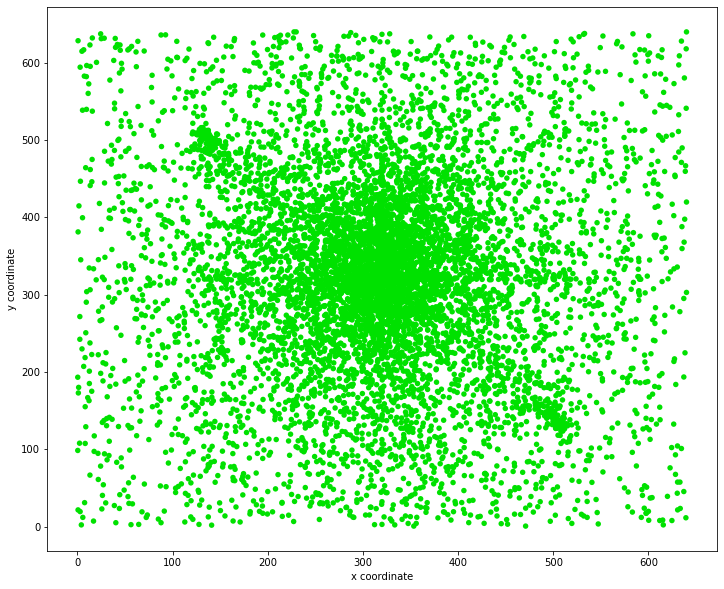

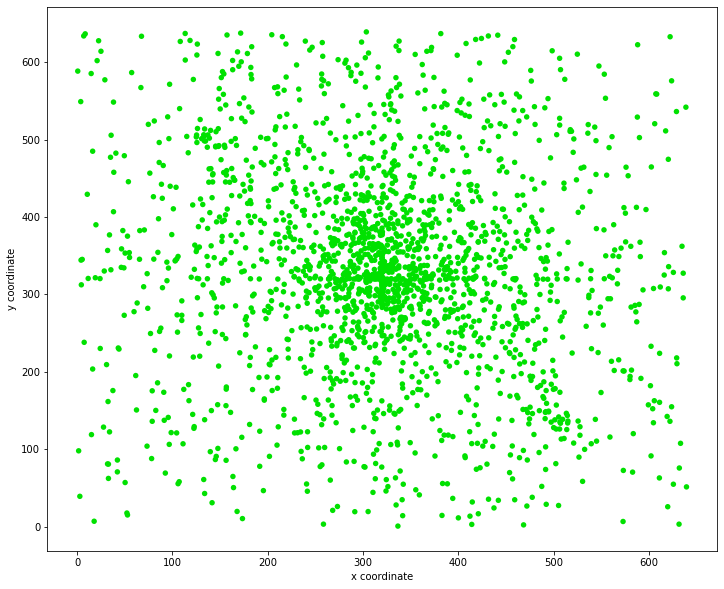

[ 0  1  4  9 16 25 36 49 64 81]


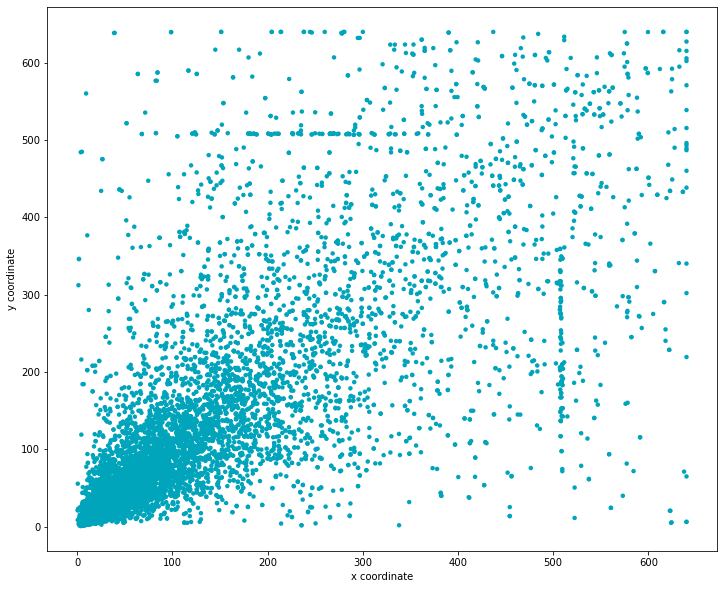

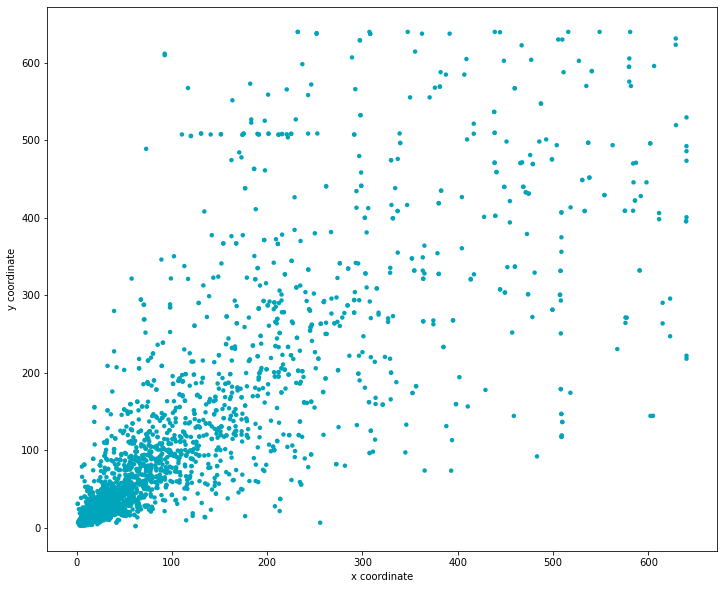

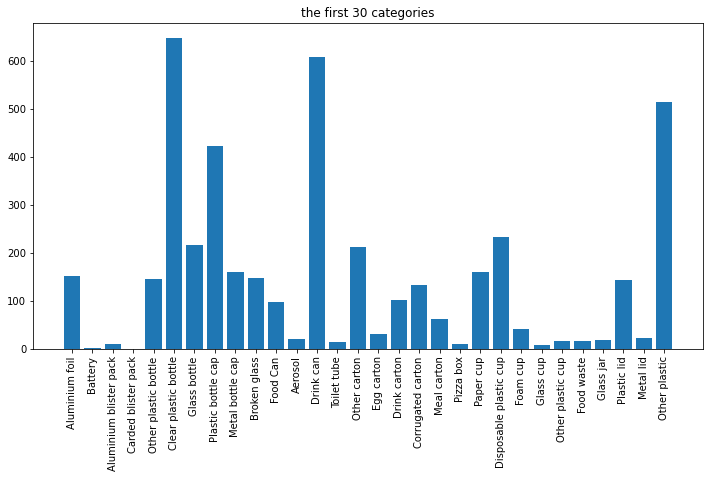

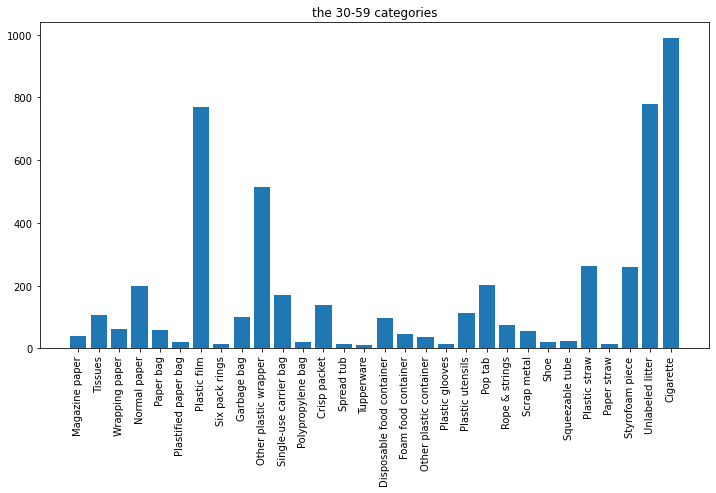

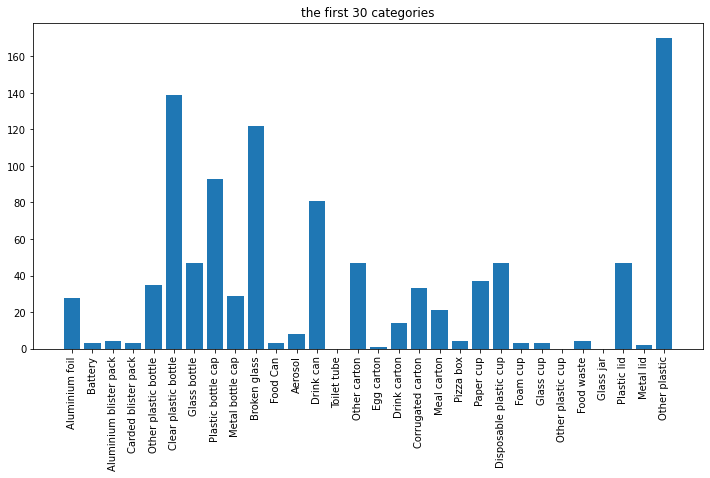

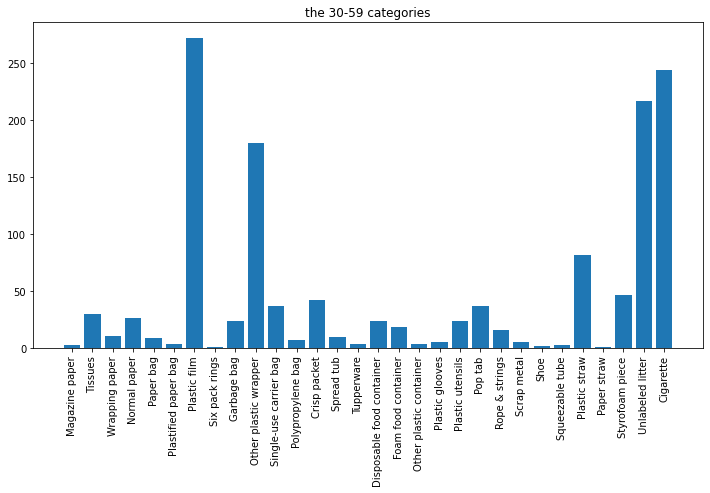

In [8]:
from matplotlib import pyplot as plt

ann_filepath = os.path.join("/media/pavel/tmp/taco2/data/" , 'annotations.json')
with open(ann_filepath, 'r') as f:
    ds = json.load(f)

#print(ds['categories'])
im_files = {c['id']:c for c in ds['images']}

annotations = get_many_annotations(ds)

def get_bounding_box_centers(im_files, annotations):
    from functools import reduce
    res = [[(min(640, a['bbox'][0] + (a['bbox'][2]/2)), min(640, a['bbox'][1] + (a['bbox'][3]/2))) for a in annotations[i]] for i in im_files.keys()]
    centers = list(reduce(lambda x, y: x+y, res))
    return centers

def get_bounding_box_sizes(im_files, annotations):
    from functools import reduce
    res = [[(min(640, a['bbox'][2]), min(640, a['bbox'][3])) for a in annotations[i]] for i in im_files.keys()]
    wh_sizes = list(reduce(lambda x, y: x+y, res))
    return wh_sizes

def count_categories(im_files, annotations):
    from functools import reduce
    res = [[a['category_id'] for a in annotations[i]] for i in im_files.keys()]
    categories = list(reduce(lambda x, y: x+y, res))
    result = {}
    for c in range(60):
        result[c] = len(list(filter(lambda x: x == c, categories)))
    res = {ds['categories'][x]['name']: result[x] for x in range(60)}
    return res


def plot_graphs(centers, n):
    """ draw scatter plot of words similarities with gender vector gender_v VS word number """
    x = np.array([c[0] for c in centers])
    y = np.array([c[1] for c in centers])
    colors = [1.7 for i in range(len(centers))]
    plt.figure(figsize=(12,10))
    plt.scatter(x, y, vmin=0, vmax=3, c=colors, 
                edgecolor='none',  s=30,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.ylabel("y coordinate")
    plt.xlabel("x coordinate")
    #plt.savefig(f'bbox_centers_{n}.jpg', bbox_inches='tight')
    plt.show()
    return

def plot_bbox_by_size(sizes, n):
    """ draw scatter plot of words similarities with gender vector gender_v VS word number """
    x = np.array([c[0] for c in sizes])
    y = np.array([c[1] for c in sizes])
    colors = [1.1 for i in range(len(sizes))]
    plt.figure(figsize=(12,10))
    plt.scatter(x, y, vmin=0, vmax=3, c=colors, 
                edgecolor='none',  s=20,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.ylabel("y coordinate")
    plt.xlabel("x coordinate")
    plt.savefig(f'bbox_w_h_sizes_{n}.jpg', bbox_inches='tight')
    plt.show()
    return

with open(os.path.join("/media/pavel/tmp/taco2/data/" , 'annotations_val.json'), 'r') as f:
    dd = json.load(f)
im2 = {c['id']:c for c in dd['images']}
annot2 = get_many_annotations(dd)

plot_graphs(get_bounding_box_centers(im_files, annotations), 1)
plot_graphs(get_bounding_box_centers(im2, annot2), 2)

#MATPLOTLIB pyplot axhline
#MATPLOTLIB pyplot axvline

x = np.array(np.arange(10))
y = np.array(x**2)
print(y)

# d = {'class': ['fir','sec'], 'category': ['', ''], 'sizepercategory':['', '']}
#sns.factorplot("sizepercategory","category", col="class", data=ddf, kind="bar")
plot_bbox_by_size(get_bounding_box_sizes(im_files, annotations), 3)
plot_bbox_by_size(get_bounding_box_sizes(im2, annot2), 4)

ccc = count_categories(im_files, annotations)


plt.figure(figsize=(12,6))
plt.bar(range(30), list(ccc.values())[:30], align="center")
plt.xticks(range(30), list(ccc.keys())[:30], rotation=90) #ticks =
plt.title("the first 30 categories")
plt.savefig(f'categories_bar_30.jpg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
plt.bar(range(30), list(ccc.values())[30:], align="center")
plt.xticks(range(30), list(ccc.keys())[30:], rotation=90) #ticks =
plt.title("the 30-59 categories")
plt.savefig(f'categories_bar_60.jpg', bbox_inches='tight')
plt.show()

ccc = count_categories(im2, annot2)


plt.figure(figsize=(12,6))
plt.bar(range(30), list(ccc.values())[:30], align="center")
plt.xticks(range(30), list(ccc.keys())[:30], rotation=90) #ticks =
plt.title("the first 30 categories")
plt.savefig(f'categories_bar_30_test.jpg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
plt.bar(range(30), list(ccc.values())[30:], align="center")
plt.xticks(range(30), list(ccc.keys())[30:], rotation=90) #ticks =
plt.title("the 30-59 categories")
plt.savefig(f'categories_bar_60_test.jpg', bbox_inches='tight')
plt.show()

In [4]:
green = "batch_14/*"
green_backgrounds = [
    "batch_7/000060.JPG",
    "batch_8/000061.JPG",
    "batch_7/000062.JPG",
    "batch_8/000063.JPG",
    "batch_7/000064.JPG",
    "batch_8/000065.JPG",
    "batch_7/000066.JPG",
    "batch_8/000067.JPG",
    "batch_7/000068.JPG",
    "batch_8/000069.JPG",
    "batch_8/000070.JPG",
    "batch_8/000071.JPG",
    "batch_8/000076.JPG",
    "batch_8/000077.JPG",
    "batch_8/000078.JPG",
    "batch_9/000003.JPG",
    "batch_9/000057.JPG",
    "batch_9/000073.JPG",
    "batch_9/000074.JPG",
    "batch_9/000075.JPG",
    "batch_10/000016.JPG",
    "batch_10/000017.JPG",
    "batch_10/000018.JPG",
    "batch_10/000019.JPG",
    "batch_10/000028.JPG",
    "batch_11/000060.JPG",
    "batch_11/000065.JPG",
    "batch_11/000066.JPG",
    "batch_11/000037.JPG",
    "batch_11/000092.JPG",
    "batch_12/000092.JPG",
    "batch_12/000095.JPG",
    "batch_15/000023.JPG",
    "batch_15/000024.JPG",
    "batch_15/000025.JPG",
    "batch_15/000026.JPG",
    "batch_15/000028.JPG",
    "batch_15/000029.JPG",
    "batch_15/000030.JPG",
    "batch_15/000037.JPG",
    "batch_15/000040.JPG",
    "batch_15/000043.JPG",
    "batch_15/000045.JPG",
    "batch_15/000054.JPG",
    "batch_15/000060.JPG",
    "batch_15/000061.JPG",
    "batch_15/000062.JPG",
    "batch_15/000063.JPG",
    "batch_15/000067.JPG",
    "batch_15/000070.JPG",
    "batch_15/000071.JPG",
    "batch_15/000072.JPG",
    "batch_15/000073.JPG",
    "batch_15/000074.JPG",
    "batch_15/000080.JPG",
    "batch_15/000081.JPG",
    "batch_15/000082.JPG"]
TO_REMOVE = [
    "batch_2/000018.JPG",
    "batch_2/000021.JPG",
    "batch_2/000024.JPG",
    "batch_3/IMG_4934.JPG",
    "batch_3/IMG_4969.JPG",
    "batch_3/IMG_5053.JPG",
    "batch_4/000020.JPG",
    "batch_4/000039.JPG",
    "batch_4/000048.JPG",
    "batch_5/000048.JPG",
    "batch_6/000048.JPG",
    "batch_6/000090.JPG",
    "batch_7/000030.JPG",
    "batch_7/000090.JPG",
    "batch_10/000011.JPG",
    "batch_10/000075.JPG",
    "batch_10/000082.JPG",
    "batch_10/000091.JPG",
    "batch_10/000093.JPG",
    "batch_12/000038.JPG",
    "batch_13/000025.JPG",
    "batch_15/000015.JPG",
    ]
do_not_rotate=[
    "batch_3/IMG_5058.JPG",
    "batch_4/000023.JPG",
    "batch_4/000046.JPG",
    "batch_4/000064.JPG",
    "batch_4/000067.JPG",
    "batch_4/000077.JPG",
    "batch_5/000026.JPG",
    "batch_5/000079.JPG",
    "batch_5/000083.JPG",
    "batch_5/000091.JPG",
    "batch_6/000008.JPG",
    "batch_6/000083.JPG",
    "batch_6/000086.JPG",
    "batch_6/000095.JPG",
    "batch_6/000099.JPG",
    "batch_6/000103.JPG",
    "batch_7/000002.JPG",
    "batch_7/000054.JPG",
    "batch_7/000101.JPG",
    "batch_7/000112.JPG",
    "batch_7/000113.JPG",
    "batch_8/000015.JPG",
    "batch_8/000042.JPG",
    "batch_8/000045.JPG",
    "batch_8/000050.JPG",
    "batch_8/000064.JPG",
    "batch_9/000018.JPG",
    "batch_9/000020.JPG",
    "batch_9/000021.JPG",
    "batch_9/000064.JPG",
    "batch_9/000070.JPG",
    "batch_9/000089.JPG",
    "batch_10/000010.JPG",
    "batch_10/000030.JPG",
    "batch_10/000080.JPG",
    "batch_10/000090.JPG",
    "batch_10/000092.JPG",
    "batch_10/000094.JPG",
    "batch_11/000028.JPG",
    "batch_11/000060.JPG",
    "batch_11/000065.JPG",
    "batch_12/000095.JPG",
    "batch_13/000011.JPG",
    "batch_14/000050.JPG",
    "batch_14/000051.JPG",
    "batch_14/000053.JPG",
    "batch_14/000054.JPG",   
    ]

print(set(do_not_rotate).intersection(set(TO_REMOVE)), len(do_not_rotate))
print(set(green_backgrounds).intersection(set(TO_REMOVE)))

set() 47
set()


In [5]:
def show_black_boxes(img, bounding_boxes):
    show_new_bounding_boxes(img, bounding_boxes, fill = 0)
    return


def show_red_bounding_boxes(img, bounding_boxes, fill = 255):
    draw = ImageDraw.Draw(img)
    for nb in bounding_boxes:
        # horizontal lines
        draw.line(([nb[0], nb[1], nb[0] + nb[2], nb[1]]), width=4, fill=fill)
        draw.line(([nb[0], nb[1] + nb[3], nb[0] + nb[2], nb[1] + nb[3]]), fill=fill, width=4)
        # vertical lines
        draw.line(([nb[0], nb[1], nb[0], nb[1] + nb[3]]), fill=fill, width=4)
        draw.line(([nb[0] + nb[2], nb[1], nb[0] + nb[2], nb[1] + nb[3]]), fill=fill, width=4)
        if fill > 51:
            fill -= 50
    return


def show_bounding_boxes(img, bounding_boxes, fill = 255):
    show_red_bounding_boxes(img, bounding_boxes)
    return

STAT = []         # List with images statistics
CAT_STAT = {}

In [6]:
PAD_SIZE = 640
MAX_CROPS = 2
IQUALITY = 95
DSIZE= (640, 640) # Size of typical crop
KINFLATE = 1.6    # Coefficient for inflation step
KINCREASE = 1.25  # Coefficient for increase step
DELTA = 10        # recommended length between a bounding box and a rectangle for cropping
BOX_INCREASE=50   # How much crop rectangle can be increased
SHOW_BBOXES = False
IS_TEST_DS = True
SPLIT = 'l'

def intersect_area(box1, box2):
    """
        Calculate intersect. area
    """ 
    # lower right xy
    xy2 = box1[:2] + box1[2:]
    xy2_t = box2[:2] + box2[2:]
    # top left intersect coordinates
    tl_intersect = np.max(np.array([box1[:2], box2[:2]]), axis=0)
    # bottom right intersect coordinates
    br_intersect = np.min(np.array([xy2, xy2_t]), axis=0)
    # gt box and pred box intersect
    is_intersect = (tl_intersect < br_intersect).astype(float).prod(axis=0)
    area_i = np.prod(br_intersect - tl_intersect, axis=0) * is_intersect
    return float(area_i)

def iou_score(box1, box2, epsilon=10e-8):
    """
        Calculate Intersect. over Union using numpy
    """ 
    # lower right xy
    xy2 = box1[:2] + box1[2:]
    xy2_t = box2[:2] + box2[2:]
    # top left intersect coordinates
    tl_intersect = np.max(np.array([box1[:2], box2[:2]]), axis=0)
    # bottom right intersect coordinates
    br_intersect = np.min(np.array([xy2, xy2_t]), axis=0)
    # gt box and pred box intersect
    is_intersect = (tl_intersect < br_intersect).astype(float).prod(axis=0)
    #is_intersect = [(tl_intersect[:,0] < br_intersect[:,0]) and (tl_intersect[:,1] < br_intersect[:,1])]
    area_i = np.prod(br_intersect - tl_intersect, axis=0) * is_intersect
    area_p = np.prod(box1[2:], axis=0)
    area_g = np.prod(box2[2:], axis=0)

    iou = (area_i) / (area_p + area_g - area_i + epsilon)
    return float(np.abs(iou))

def remove_img(dsj, to_remove):
    """
       return list with images where file_name is not in to_remove list
    """
    result = [img for img in dsj['images'] if img['file_name'].lower() not in to_remove]
    return result, [img['id'] for img in result]

def remove_annotations(dsj, ids):
    """
       return list with annotations where image_id is not in ids list
    """
    return [a for a in dsj['annotations'] if a['image_id'] in ids]

def remove_21_annotations(input_dir, remove, files):
    """
       remove annotations with file names in remove list
    """
    dont_rotate_lower = [path.lower() for path in files]
    remove_lower_case = [p.lower() for p in remove]
    
    with open(input_dir, 'r') as f:
        dsj = json.load(f)
    imgs, ids = remove_img(dsj, remove_lower_case)
    annotations = remove_annotations(dsj, ids)
    print("new annotations/ old", len(annotations), len(dsj['annotations']))
    ids_rotate = [img['id'] for img in dsj['images'] if img['file_name'].lower() not in dont_rotate_lower]
    ids_dont_rotate = [img['id'] for img in dsj['images'] if (img['file_name'].lower()) in dont_rotate_lower]
    data = {}
    for k in dsj.keys():
        if k=='images':
            data[k] = imgs
        elif k=='annotations':
            data[k] = annotations
        else:
            data[k] = dsj[k]
    print("rotate / remove", len(ids_rotate), len(TO_REMOVE))
    return data, list(set(ids).intersection(set(ids_rotate))), list(set(ids).intersection(set(ids_dont_rotate)))


def conv_bboxes_180(bboxes, wsize, hsize):
    bboxes2 = deepcopy(bboxes)
    for bbox in bboxes2:
        new_x = wsize - bbox[0] - bbox[2]
        new_y = hsize - bbox[1] - bbox[3]
        bbox[0] = new_x
        bbox[1] = new_y
    return bboxes2


def conv_bboxes_270(bboxes, wsize, hsize):
    bbs = deepcopy(bboxes)
    for bbox in bbs:
        new_x = hsize - bbox[1] - bbox[3]
        new_y = bbox[0]
        w_x = bbox[3]
        h_y = bbox[2]
        bbox[0] = new_x
        bbox[1] = new_y
        bbox[2] = w_x
        bbox[3] = h_y
    return bbs


def conv_bboxes_90(bboxes, wsize, hsize):
    bbs = deepcopy(bboxes)
    for bbox in bbs:
        new_x = bbox[1]
        new_y = wsize - bbox[0] - bbox[2]
        w_x = bbox[3]
        h_y = bbox[2]
        bbox[0] = new_x
        bbox[1] = new_y
        bbox[2] = w_x
        bbox[3] = h_y
    return bbs


def conv_bbox_180(bbox, wsize, hsize):
    if bbox is None:
        return None
    new_x = wsize - bbox[0] - bbox[2]
    new_y = hsize - bbox[1] - bbox[3]
    return [new_x, new_y, bbox[2], bbox[3]]


def conv_bbox_270(bbox, wsize, hsize):
    if bbox is None:
        return None
    new_x = hsize - bbox[1] - bbox[3]
    new_y = bbox[0]
    return [new_x, new_y, bbox[3], bbox[2]]


def conv_bbox_90(bbox, wsize, hsize):
    if bbox is None:
        return None
    new_x = bbox[1]
    new_y = wsize - bbox[0] - bbox[2]
    return [new_x, new_y, bbox[3], bbox[2]]


def fit_limits(x1, y1, x2, y2, w, h, boundary):
    """
       adjust box to be outside of boundary coordinates
       w: width of an image
       h: height of an image
       boundary: list with coordinates of a boundary [x1, y1, width, height]
    """
    # if B R corner withing limits
    if boundary[1] < y1 and y2 < (boundary[1] + boundary[3]):
        if x1 < boundary[0] < x2:
            delta = x2 - boundary[0]
            x1 = 0. if x1 < delta else (x1 - delta)
            x2 = boundary[0]
        elif x1 < (boundary[0] + boundary[2]) < x2: # if U L corner withing limits
            delta = boundary[0] + boundary[2] - x1
            x2 = (w-1) if (w-1 - x2) < delta else (x2 + delta)
            x1 = boundary[0] + boundary[2]
    # if B R corner withing limits
    if boundary[0] < x1 and x2 < (boundary[0] + boundary[2]):
        if y1 < boundary[1] < y2:
            delta = y2 - boundary[1]
            y1 = 0. if y1 < delta else (y1 - delta)
            y2 = boundary[1]
        elif y1 < (boundary[1] + boundary[3]) < y2: # if U L corner withing limits
            delta = boundary[1] + boundary[3] - y1
            y2 = (h-1) if (h-1 - y2) < delta else (y2 + delta)
            y1 = boundary[0] + boundary[3]
    return (x1, y1, x2, y2)

def adjust_bounding_boxes(boxes, categories, crop_rec, x_inv_ratio, y_inv_ratio):
    """
       Adjust all bounding boxes according to top-left coordinates x, y of a crop and x_ratio, y_ratio 
       of resizing operation.
       
       crop_rec: rectangle coordinates for crop (x1, y1, x2, y2)
       x_ratio, y_ratio: ratios of resizing operation
       boundary: list with coordinates of a boundary [x1, y1, width, height]
    """
    rectangle = np.array([crop_rec[0], crop_rec[1], crop_rec[2] - crop_rec[0], crop_rec[3] - crop_rec[1]])
    results = [(box, c) for box, c in zip(deepcopy(boxes), categories) 
               if intersect_area(np.array(box), rectangle) > 10e-9]
    boxes, categ = [], [x[1] for x in results]
    for box, c in results:
        x_max = min(crop_rec[2] - crop_rec[0], box[0] + box[2] - crop_rec[0])
        y_max = min(crop_rec[3] - crop_rec[1], box[1] + box[3] - crop_rec[1])
        coord = max(0., box[0] - crop_rec[0])
        box[2] = (x_max - coord) * x_inv_ratio
        box[0] = coord * x_inv_ratio
        coord2 = max(0., box[1] - crop_rec[1])
        box[3] = (y_max - coord2) * y_inv_ratio
        box[1] = coord2 * y_inv_ratio
        boxes.append(box)
    return boxes, categ

def calc_new_bbox_coordinates(img, wid, hei, box):
    """
       calculation of the bounding box coordinates
    """
    w, h = img.size
    #sanity check
    if wid < box[2]:
        wid = box[2]
    if hei < box[3]:
        hei = box[3]
        
    # calculating deltas
    dx1 = int(wid / 2)
    dx2 = wid - dx1
    dy1 = int(hei / 2)
    dy2 = hei - dy1
    # box center
    xc = int(box[0] + int(box[2] / 2))
    yc = int(box[1] + int(box[3] / 2))
    # lower right corner
    x2 = xc + dx2
    y2 = yc + dy2
    # if geater than boundaries ajust dx1, dy1
    if x2 > w:
        dx1 += (x2-w)
        x2 = w
    if y2 > h:
        dy1 += (y2-h)
        y2 = h
    # upper left corner
    x1 = max(0., xc - dx1)
    y1 = max(0., yc - dy1)
    return x1, y1, x2, y2
    
def box_for_simple_crop(img, wid, hei, boxes, boundary=None):
    """
       calculate new box using rectangle with size (wid, hei) around the center of box[0]
    """
    box = boxes[0]
    x1, y1, x2, y2 = calc_new_bbox_coordinates(img, wid, hei, box)
    if boundary is not None and len(boundary) == 4:
        # check size of intersection area
        int_area = intersect_area(np.array([x1, y1, x2 - x1, y2 - y1]), np.array(boundary))
        if int_area > 10e-14 and ((x1 < boundary[0] < x2) or  # if B R corner withing limits
                (x1 < (boundary[0] + boundary[2]) < x2) or # if U L corner withing limits
                (y1 < boundary[1] < y2) or
                (y1 < (boundary[1] + boundary[3]) < y2)): # if U L corner withing limits
            w, h = img.size
            x1, y1, x2, y2 = fit_limits(x1, y1, x2, y2, w, h, boundary)
    return x1, y1, x2, y2


def smart_crop(img, wid, hei, boxes, categories, boundary=None, union=None):
    """
       if union area was provided, crop image with rectangle (wid, hei) size around the center of union
       In the other case do simple crop for box[0]
    """
    if union is not None:
        x1, y1, x2, y2 = calc_new_bbox_coordinates(img, wid, hei, union)
    else:
        x1, y1, x2, y2 = box_for_simple_crop(img, wid, hei, boxes, boundary)
    # new box coordinates after crop & resize
    x_inv_ratio = DSIZE[0] / (x2 - x1)
    y_inv_ratio = DSIZE[1] / (y2 - y1)
    bounding_boxes, categ = adjust_bounding_boxes(boxes, categories, (x1, y1, x2, y2), 
                                                       x_inv_ratio, y_inv_ratio)

    img = img.crop((x1, y1, x2, y2))
    img = img.resize(DSIZE)
    if SHOW_BBOXES:
        show_bounding_boxes(img, bounding_boxes)
    return img, bounding_boxes, categ
        

def crop1(img, boxes, categories, boundary=None, union=None):
    """
       Calculate width and height of an area around box 
       And crop one rectangle from image img
    """
    box = union if union is not None else boxes[0].copy()
    w, h = img.size
    wid = min(DSIZE[0] * KINFLATE, w)
    hei = min(DSIZE[1] * KINFLATE, h)
    w, h = img.size
    # choosing width and height for crop with correct aspect ratio
    if wid >= box[2] and hei >= box[3]:
        return smart_crop(img, wid, hei, boxes, categories, boundary, union)
    elif wid >= box[2] and hei < box[3]:
        hei = min(h, box[3] + DELTA) * KINCREASE
        wid = min(w, int(hei * DSIZE[0] / DSIZE[1])) * KINCREASE
        return smart_crop(img, wid, hei, boxes, categories, boundary, union)
    elif wid < box[2] and hei >= box[3]:
        wid = min(w, box[2] + DELTA) * KINCREASE
        hei = min(h, int(wid * DSIZE[1] / DSIZE[0])) * KINCREASE
        return smart_crop(img, wid, hei, boxes, categories, boundary, union)
    # increasing width and height for crop to match bounding box
    while (wid < box[2] or hei < box[3]):
        wid *= KINFLATE
        hei *= KINFLATE
    w, h = img.size
    if wid >= w or hei >= h:
        if w < h:
            wid = w
            hei = min(int(w * DSIZE[1] / DSIZE[0]), h)
        else:
            hei = h
            wid = min(int(h * DSIZE[0] / DSIZE[1]), w)
    return smart_crop(img, wid, hei, boxes, categories, boundary, union)

def include_batch_to_names(path, suffix, sp = SPLIT):
    """
       create 4 names with batch and suffix added
    """
    extension, space, separator = '.jpg', '_', '/'
    batch_name = path[(path.rfind(separator) - 5):]
    batch_index = batch_name.find(sp)
    bn = batch_name.replace(separator, space)
    name = f"BT{bn[batch_index: -4]}"
    names = [f"{name}{suffix}{i}{extension}" for i in range(4)]
    return names

def do_4_crops(path, boxes, categories, output_dir, suffix, rotate=True, boundary=None, union=None): 
    ##TO_DO add strategy pattern
    """
       do 4 crops with rotation by 90, 180 and 270 degrees
    """
    names = include_batch_to_names(path, suffix)
    img = Image.open(path)
    w, h = img.size
    cr_img1, cr_box1, category1 = crop1(img, boxes, categories, boundary=boundary, union=union)
    cr_img1.save(os.path.join(output_dir, names[0]), quality=IQUALITY)
    img1 = img.transpose(Image.ROTATE_180)
    bboxes1 = conv_bboxes_180(boxes, w, h)
    bound2 = conv_bbox_180(boundary, w, h)
    union2 = conv_bbox_180(union, w, h)
    cr_img2, cr_box2, category2 = crop1(img1, bboxes1, categories, boundary=bound2, union=union2)
    cr_img2.save(os.path.join(output_dir, names[1]), quality=IQUALITY)
    img2 = img.transpose(Image.ROTATE_90)
    bboxes2 = conv_bboxes_90(boxes, w, h)
    bound2 = conv_bbox_90(boundary, w, h)
    union2 = conv_bbox_90(union, w, h)
    cr_img3, cr_box3, category3 = crop1(img2, bboxes2, categories, boundary=bound2, union=union2)
    cr_img3.save(os.path.join(output_dir, names[2]), quality=IQUALITY)
    img = img.transpose(Image.ROTATE_270)
    bboxes2 = conv_bboxes_270(boxes, w, h)
    bound2 = conv_bbox_270(boundary, w, h)
    union2 = conv_bbox_270(union, w, h)
    cr_img4, cr_box4, category4 = crop1(img, bboxes2, categories, boundary=bound2, union=union2)
    cr_img4.save(os.path.join(output_dir, names[3]), quality=IQUALITY)
    cr_img2.close()
    cr_img3.close()
    cr_img1.close()
    img.close()
    cr_img4.close()
    return list(zip(names, [cr_box1, cr_box2, cr_box3, cr_box4], [category1, category2, category3, category4]))

def do_270_crop(path, boxes, categories, output_dir, suffix, boundary=None, union=None, sp = SPLIT): 
    """
       do one crop and one crop with rotation by 270 degrees
    """ 
    names = include_batch_to_names(path, suffix, sp=sp)
    img = Image.open(path)
    w, h = img.size
    cr_img1, cr_box1, category1 = crop1(img, boxes, categories, boundary=boundary, union=union)
    cr_img1.save(os.path.join(output_dir, names[0]), quality=IQUALITY)
    # crop with rotation
    img = img.transpose(Image.ROTATE_270)
    bboxes2 = conv_bboxes_270(boxes, w, h)
    bound2 = conv_bbox_270(boundary, w, h)
    union2 = conv_bbox_270(union, w, h)
    cr_img4, cr_box4, category4 = crop1(img, bboxes2, categories, boundary=bound2, union=union2)
    cr_img4.save(os.path.join(output_dir, names[1]), quality=IQUALITY)
    img.close()
    cr_img4.close()
    return list(zip(names[:2], [cr_box1, cr_box4], [category1, category4]))

def valid_crop(path, boxes, categories, output_dir, suffix, boundary=None, union=None, sp = SPLIT): 
    """
       do 1st crop with rotation by 90 degrees and 2nd crop with rotation by 270 degrees
    """
    names = include_batch_to_names(path, suffix, sp=sp)
    img = Image.open(path)
    w, h = img.size
    img2 = img.transpose(Image.ROTATE_90)
    bboxes2 = conv_bboxes_90(boxes, w, h)
    bound2 = conv_bbox_90(boundary, w, h)
    union2 = conv_bbox_90(union, w, h)
    cr_img3, cr_box3, category3 = crop1(img2, bboxes2, categories, boundary=bound2, union=union2)
    cr_img3.save(os.path.join(output_dir, names[0]), quality=IQUALITY)
    img = img.transpose(Image.ROTATE_270)
    bboxes2 = conv_bboxes_270(boxes, w, h)
    bound2 = conv_bbox_270(boundary, w, h)
    union2 = conv_bbox_270(union, w, h)
    cr_img4, cr_box4, category4 = crop1(img, bboxes2, categories, boundary=bound2, union=union2)
    cr_img4.save(os.path.join(output_dir, names[1]), quality=IQUALITY)
    img.close()
    cr_img3.close()
    cr_img4.close()
    return list(zip(names[:2], [cr_box3, cr_box4], [category3, category4]))


def do_crops_without_rotation(path, boxes, categories, output_dir):
    """
       do 1 crop without rotation
    """
    return do_4_crops(path, boxes, categories, output_dir, rotate=False)


def get_limitation_boxes(inter_area, box1, box2, w, h, epsilon=10e-11):
    """
        draw boundary line between box 1 and box 2 if intersection area equals zero
        returns linitation boxes according to boundary line
    """
    if np.abs(inter_area) > epsilon:
        return (box2.tolist(), box1.tolist())
    
    limit_box1 = [0.,0., w, h]
    limit_box2 = [0.,0., w, h]
    sign_w = box1[0] - box2[0]
    sign_h = box1[1] - box2[1]
    if (box1[0] + box1[2]) < box2[0] or (box2[0] + box2[2]) < box1[0]:
        if sign_w < 0: # box2 center x > box1 center x with IoU=0
            boundary_x = int((box1[0] + box1[2] + box2[0]) / 2)
            limit_box2[0] = 0.
            limit_box2[2] = boundary_x
            limit_box1[0] = boundary_x
            limit_box1[2] = w - boundary_x
        else:
            boundary_x = int((box1[0] + box2[0] + box2[2]) / 2)
            limit_box2[0] = boundary_x
            limit_box2[2] = w - boundary_x
            limit_box1[0] = 0.
            limit_box1[2] = boundary_x

    if (box1[1] + box1[3]) < box2[1] or (box2[1] + box2[3]) < box1[1]:
        if sign_h < 0: # box2 center y > box1 center y with IoU=0
            boundary_y = int((box1[1] + box1[3] + box2[1]) / 2)
            limit_box2[1] = 0.
            limit_box2[3] = boundary_y
            limit_box1[1] = boundary_y
            limit_box1[3] = h - boundary_y
        else:
            boundary_y = int((box1[1] + box2[1] + box2[3]) / 2)
            limit_box2[1] = boundary_y
            limit_box2[3] = h - boundary_y
            limit_box1[1] = 0.
            limit_box1[3] = boundary_y
          
    return (limit_box1, limit_box2)


def iou_score(box1, box2, epsilon=10e-8):
    """
        Calculate intersect over Union using numpy
    """ 
    # lower right xy
    xy2 = box1[:2] + box1[2:]
    xy2_t = box2[:2] + box2[2:]
    # top left intersect. coordinates
    tl_intersect = np.max(np.array([box1[:2], box2[:2]]), axis=0)
    # bottom right intersect. coordinates
    br_intersect = np.min(np.array([xy2, xy2_t]), axis=0)
    # gt box and pred box intersect.
    is_intersect = (tl_intersect < br_intersect).astype(float).prod(axis=0)
    #is_intersect = [(tl_intersect[:,0] < br_intersect[:,0]) and (tl_intersect[:,1] < br_intersect[:,1])]
    area_i = np.prod(br_intersect - tl_intersect, axis=0) * is_intersect
    area_p = np.prod(box1[2:], axis=0)
    area_g = np.prod(box2[2:], axis=0)

    iou = (area_i) / (area_p + area_g - area_i + epsilon)
    return float(np.abs(iou))
 
    
def intersect_with_limits(box1, box2, w, h, epsilon=10e-8):
    """
        Calculate intersection area for box1, box2 and limitation boxes for box1, box2
        returns intersection area, limitation box1, limitation box2
    """ 
    inter_area = intersect_area(box1, box2)
    limit_box1, limit_box2 = get_limitation_boxes(inter_area, box1, box2, w, h, epsilon=epsilon)
    return inter_area, limit_box1, limit_box2


def convert_exif(path, output_dir):
    """
       convert image if exif tag 274 is set to 3 or 6 or 9
    """
    #name = path[(path.rfind("/") - 6):].replace('/', '_')
    name = path[(path.rfind("/") + 1):]
    image = Image.open(path)
    # load metadata
    exif = image._getexif()
    if exif:
        exif = dict(exif.items())
        #274 is the orientation tag code
        if 274 in exif:
            if exif[274] == 3:
                image1 = image.rotate(180, expand=True)
            if exif[274] == 6:
                image1= image.rotate(270, expand=True)
            if exif[274] == 8:
                image1 = image.rotate(90, expand=True)
            image.close()
            exif = image1._getexif()
            exif[274] = 0
            image1.save(path , quality=95)
            image1.close()
        else:
            image.close()
    else:
        image.close()
    return


def rotate_by_exif(ids, imgs, inp_dir, out_dir):
    """
        rotate images according to exif tag
    """ 
    for img in imgs.values():
        if img['id'] in ids:
            convert_exif(inp_dir + img['file_name'], out_dir)
    return

def merge_intersected_boxes(intersec_subgraphs, n, enum):
    """
        merge intersected boxes by ids in n
    """ 
    for subgr in intersec_subgraphs:
        ids = set([e[0] for e in subgr])
        if len(n.union(ids)) > 0:
            new_list = subgr.copy() + enum
            return


def get_ids_in_intersections(intersec_boxes_lst):
    """
        get ids from the intersections list
    """ 
    union_ids = set()
    for boxes in intersec_boxes_lst:
        union_ids = union_ids.union(set([e[0] for e in boxes]))
    return union_ids


def add_isolated_boxes(results, enum_boxes):
    """
        add isolated boxes
    """ 
    ids = get_ids_in_intersections(results)
    results.extend([[e] for e in enum_boxes if e[0] not in ids])
    return

    
def get_isolated_subgraphs(enum_boxes, epsilon=0.1):
    """
        get isolated clusters of bounding boxes without intersections
        attribute enum_boxes contained enumerated bounding boxes (n, bbox)
    """
    results = []
    
    if len(enum_boxes) == 2:
        box1 = enum_boxes[0][1]
        box2 = enum_boxes[1][1]
        area = intersect_area(np.array(box1), np.array(box2))
        return [enum_boxes] if area>epsilon else [[enum_boxes[0]], [enum_boxes[1]]]
    
    intersec_subgraphs = []
    if len(enum_boxes) >= 3:
        for i in range(len(enum_boxes) - 1):
            enum = enum_boxes[i] # box with index i
            # ids of boxes with existing intersections
            inters = set() if i == 0 else get_ids_in_intersections(intersec_subgraphs)
            # find intersections for box i
            intersections = [enum_boxes[k] for k in range(i + 1, len(enum_boxes)) 
                     if intersect_area(np.array(enum[1]), np.array(enum_boxes[k][1])) > epsilon]
            ids = set([enum[0]] + [e[0] for e in intersections])
            n = inters.intersection(ids)
            if len(n) == 0:
                intersections.append(enum)
                intersec_subgraphs.append(intersections)
            else:
                intersections.append(enum)
                merge_intersected_boxes(intersec_subgraphs, n, intersections)
        # add isolated boxes with zero intersections    
        add_isolated_boxes(intersec_subgraphs, enum_boxes)
    return sorted(intersec_subgraphs, key=lambda x: len(x), reverse=True)


def take_large_crops(path, boxes, categories, output_dir, suffix, is_background=False, sp=SPLIT):
    """
       take two large crops from original image and two large crops from image rotated 180 degrees
    """
    names = include_batch_to_names(path, suffix, sp=sp)
    img = Image.open(path)
    rotate = img.transpose(Image.ROTATE_180)
    w, h = img.size
    d = min(w , h)
    crops = [[0, 0, d, d], [w - d, h - d, w, h], [0, 0, d, d], [w - d, h - d, w, h]]
    bboxes1 = conv_bboxes_180(boxes, w, h)
    bboxes = [boxes, deepcopy(boxes), bboxes1, deepcopy(bboxes1)]
    adj_categories, adj_boxes = [], []
    
    for i in range(4):
        x1, y1, x2, y2 = crops[i][0], crops[i][1], crops[i][2], crops[i][3]
        x_inv_ratio = DSIZE[0] / (x2 - x1)
        y_inv_ratio = DSIZE[1] / (y2 - y1)
        bounding_boxes, categs = adjust_bounding_boxes(bboxes[i], categories, (x1, y1, x2, y2), 
                                                       x_inv_ratio, y_inv_ratio)
        img1 = rotate if i > 1 else img
        img1 = img1.crop(crops[i])
        img1 = img1.resize(DSIZE)
        
        if is_background:
            adj_categories.append([-1 for c in categs])
            show_black_boxes(img1, bounding_boxes)
        else:
            adj_categories.append(categs)    
        img1.save(os.path.join(output_dir, names[i]), quality=IQUALITY)
        img1.close()
        adj_boxes.append(bounding_boxes)
    img.close()
    return list(zip(names, adj_boxes, adj_categories))

def adjust_boxes(bboxes, ratios, padx, pady):
    """
       adjust boxes according to ratios
    """
    prods = bboxes * ratios
    prods = prods + np.array([[padx, pady, 0, 0]])
    return [prods[i].tolist() for i in range(len(bboxes))]


def resize_with_pad(path, boxes, categories, output_dir, suffix, sp=SPLIT):
    """
       do resize and pad to 640x640px for one sample 
    """
    names = include_batch_to_names(path, suffix, sp=sp)
    img = Image.open(path)
    w, h = img.size
    new_w, new_h = w , h
    # calculate new image size
    if w == h:
        new_w = DSIZE[0]
        new_h = DSIZE[1]
        pad = (0, 0)
    elif w > h:
        new_w = DSIZE[0]
        new_h = int(h * DSIZE[1] / w)
        pad = (0, int((DSIZE[1] - new_h) / 2))
    else:
        new_w = int(w * DSIZE[0] / h)
        new_h = DSIZE[1]
        pad = (int((DSIZE[0] - new_w) / 2), 0)
    bounding_boxes = adjust_boxes(np.array(boxes), np.array([[new_w / w, new_h / h, new_w / w, new_h / h]]),
                                 pad[0], pad[1])
    if len(bounding_boxes) == 0:
                print("BB size = 0: ", path, boxes)
    img1 = img.resize((new_w, new_h))
    # pad if W != H
    if new_w != new_h:
        img1 = transforms.Pad(pad)(img1)
    if SHOW_BBOXES:
        show_red_bounding_boxes(img1, bounding_boxes)
    img1.save(os.path.join(output_dir, names[0]), quality=IQUALITY)
    img1.close()
    img.close()
    return list(zip(names[:1], [bounding_boxes], [categories]))


In [7]:



def find_union_for_bboxes(boxes):
    """
       finds an union of the several intersected boxes from list
    """
    bboxes = deepcopy(boxes)
    union = [0.,0.,0.,0.]
    union[0] = max(bboxes[0][0], 0.)
    union[1] = max(bboxes[0][1], 0.)
    union[2] = bboxes[0][0] + bboxes[0][2]
    union[3] = bboxes[0][1] + bboxes[0][3]
    for i in range(1, len(boxes)):
        box = boxes[i]
        x2 = max(box[0] + box[2], union[2])
        y2 = max(box[1] + box[3], union[3])
        union[0] = min(max(box[0], 0.), union[0])
        union[1] = min(max(box[1], 0.), union[1])
        union[2] = x2
        union[3] = y2
    return [union[0], union[1], union[2] - union[0], union[3] - union[1]]

def extend_union_to_dsize(union, sizes, w, h):
    """
        increases union box width and height to DSIZE
    """
    if union[2] >= sizes[0] and union[3] >= sizes[1]:
        return union
    ext_box = [union[0], union[1], 
               sizes[0] if union[2] < sizes[0] else union[2], 
               sizes[1] if union[3] < sizes[1] else union[3]]
    if ext_box[2] > ext_box[3]:
        ext_box[3] = int(ext_box[2])
    if w < union[0] + ext_box[2]:
        # if box x coordinate too close to edge of image
        ext_box[0] = max(0., w - ext_box[2] - 1)
    if h < union[1] + ext_box[3]:
        # if box y coordinate too close to edge of image
        ext_box[1] = max(0., h - ext_box[3] - 1)
    return ext_box

def can_increase_box(box, w, h, box_increase):
    """
       returns True if box far away from image boundary (w,h)
    """
    return (box[0] + box[2]) < (w - box_increase) and (box[1] + box[3]) < (h - box_increase)

class Context():
    
    @staticmethod
    def request(strategy):
        return strategy()

class IStrategy(metaclass=ABCMeta):
    
    @staticmethod
    @abstractmethod
    def __str__():
        """ to be implemented """
        pass
    
    @staticmethod
    @abstractmethod
    def generate_samples(id_, images, annotations, inp_dir, out_dir):
        """ to be implemented """
        pass
    
class AbstractGenerator(IStrategy):
    
    def __init__(self):
        super().__init__()
        self.statistic = STAT
        self.categories = CAT_STAT
    
    def statistics(self, results, area):
        if results is not None:
            for tupl in results:
                res = (len(tupl[1]), tupl[2], sum([b[2] * b[3] for b in tupl[1]]) / area)
                for categ in tupl[2]:
                    if categ in self.categories:
                        self.categories[categ] += 1
                    else:
                        self.categories[categ] = 1
                self.statistic.append(res)

class OneItemGenerator(AbstractGenerator):
    
    def __init__(self):
        super().__init__()
        self.is_test = IS_TEST_DS
    
    def __str__(self):
        return "OneItemGenerator"
    
    def generate_samples(self, id_, images, annotations, inp_dir, out_dir):
        annots = annotations[id_]
        img = images[id_]
        categories = [a['category_id'] for a in annots]
        boxes = [a['bbox'] for a in annots]
        print(img['file_name'], boxes)
        crop_func = valid_crop if self.is_test else do_270_crop
        results = crop_func(inp_dir + img['file_name'], boxes, categories, out_dir, '_')
        self.statistics(results, img['width'] * img['height'])
        return results

class LargeCrops(AbstractGenerator):
    
    def __init__(self):
        super().__init__()
        self.is_background = False
    
    def __str__(self):
        return "LargeCrops"
    
    def generate_backgrounds(self, id_, images, annotations, inp_dir, out_dir):
        self.is_background = True
        res = self.generate_samples(id_, images, annotations, inp_dir, out_dir)
        self.is_background = False
        return res
    
    def generate_samples(self, id_, images, annotations, inp_dir, out_dir):
        annots = annotations[id_]
        img = images[id_]
        categories = [a['category_id'] for a in annots]
        boxes = [a['bbox'] for a in annots]
        results = take_large_crops(inp_dir + img['file_name'], boxes, categories, out_dir, '_', 
                                   is_background=self.is_background)
        self.statistics(results, img['width'] * img['height'])
        return results
    
class PaddedCrops(AbstractGenerator):
    
    def __init__(self):
        super().__init__()
    
    def __str__(self):
        return "PaddedCrops"
    
    def generate_samples(self, id_, images, annotations, inp_dir, out_dir):
        annots = annotations[id_]
        img = images[id_]
        categories = [a['category_id'] for a in annots]
        boxes = [a['bbox'] for a in annots]
        results = resize_with_pad(inp_dir + img['file_name'], boxes, categories, out_dir, '_')
        self.statistics(results, img['width'] * img['height'])
        return results


class MultipleItemsGenerator(AbstractGenerator):
    
    def __init__(self):
        super().__init__()
        self.is_test = IS_TEST_DS
    
    def __str__(self):
        return "MultipleItemsGenerator"

    def generate_samples(self, id_, images, annotations, inp_dir, out_dir):
        suffix = '_'
        results = [[], [], []]
        crop_count = 0
        annots = annotations[id_]
        img = images[id_]

        filename = os.path.join(inp_dir, img['file_name'])
        w, h = img['width'], img['height']
        categories = [a['category_id'] for a in annots]
        boxes = [a['bbox'] for a in annots]
        ## find clusters of items and isolated items
        subgraphs = get_isolated_subgraphs(list(enumerate(deepcopy(boxes))))
        #print("all graphs: {subgraphs}")
        # search for isolated subgraphs
        crop_func = valid_crop if self.is_test else do_270_crop
        for subgr in subgraphs:
            if len(subgr) > 1 and crop_count < MAX_CROPS:
                uni = find_union_for_bboxes([box[1] for box in subgr])
                # do 4 rotated crops for union
                results = crop_func(
                    filename, 
                    boxes, 
                    categories, 
                    out_dir, 
                    f'{suffix}{crop_count}', 
                    union=uni)
                crop_count += 1
#                 if len(subgraphs) <= 3 and can_increase_box(uni, w, h, BOX_INCREASE): 
#                     # increase union by 100px and do 4 rotated crops for union
#                     res2 = do_4_crops(
#                         filename, 
#                         boxes, 
#                         categories, 
#                         out_dir, 
#                         f'{suffix}{crop_count}A', 
#                         union=[uni[0], uni[1], uni[2] + BOX_INCREASE, uni[3] + BOX_INCREASE])
#                     results.extend(res2)
#                     crop_count += 1
            elif len(subgr) == 1 and crop_count < MAX_CROPS:
                # if there is only one isolated box, call do_4_crops with increased box size to 640x640
                results = crop_func(filename, boxes, categories, out_dir, suffix + str(crop_count), 
                                  union=extend_union_to_dsize(subgr[0][1], DSIZE, w, h))
                crop_count += 1
        self.statistics(results, w * h)
        return results

CONTEXT = Context()
print(CONTEXT.request(MultipleItemsGenerator))
print(CONTEXT.request(LargeCrops))

MultipleItemsGenerator
LargeCrops


In [55]:
TACO_PATH = '/srv/data/taco/data/'
TACO_CROPS = '/srv/data/taco/crops/'
TACO_EXIF = '/srv/data/taco/exif/'
TACO_BATCH = '/srv/data/taco/data/last_batch/'
TACO_LARGE = '/srv/data/taco/data/large/'
TACO_BGRND = '/srv/data/taco/data/back/'


def remove_all_annotations(input_dir, fname):
    """
       remove annotations
    """
    with open(os.path.join(input_dir, fname), 'r') as f:
        dsj = json.load(f)
    data = {}
    for k in dsj.keys():
        if k=='images':
            data[k] = []
        elif k=='annotations':
            data[k] = []
        else:
            data[k] = dsj[k]
    return data

def copy_image(input_dir, out_dir, name, bounding_boxes):
    """ change image type to jpg and save image """
    name2 = name.replace("/", "_")
    image = Image.open(input_dir)
    show_red_bounding_boxes(image, bounding_boxes)
    image.save(out_dir + name2, quality=IQUALITY)
    image.close()
    return name2

def load_ds(path = TACO_PATH, name = "annotations.json"):
    filepath = os.path.join(path , name)
    with open(filepath, 'r') as f:
        return json.load(f)
    
def get_max_imageid(images):
    max_id = -1
    for i in range(len(images)-1, 0, -1):
        if images[i]['id'] > max_id:
            max_id = images[i]['id']
    return max_id

def get_max_annotation_id(annotations):
    max_id = -1
    for i in range(len(annotations)-1, 0, -1):
        if annotations[i]['id'] > max_id:
            max_id = annotations[i]['id']
    return max_id
    
def add_annotations(next_id, annots_id, dsj, result_tuples, batch, id_, images, annotations, scene):
    last_aid = annots_id
    last_id = next_id
    lid = [images]
    for tupl in result_tuples:
        if len(tupl[1]) > 0: # if more then 0 boxes exists
            last_id += 1
            image_data = deepcopy(images[id_])
            image_data['file_name'] = batch + tupl[0]
            image_data['id'] = last_id
            image_data['width'] = DSIZE[0]
            image_data['height'] = DSIZE[1]
            dsj['images'].append(image_data)
            if scene is not None:
                sc = deepcopy(scene)
                sc['image_id'] = last_id
                dsj['scene_annotations'].append(sc)

            for box, c in zip(tupl[1], tupl[2]):
                last_aid += 1
                annots = deepcopy(annotations[id_][0])          
                annots['id'] = last_aid
                annots['image_id'] = last_id
                annots['bbox'] = box
                annots['area'] = box[2]*box[3]
                annots['category_id'] = c
                annots['segmentation'] = []
                dsj['annotations'].append(annots)
    return last_id, last_aid
    
DEL1 = [
"unofficial/001685.jpg",
"unofficial/001211.jpg",
"unofficial/001218.jpg",
"unofficial/001021.jpg",
"unofficial/000020.jpg",
"unofficial/000039.jpg",
"unofficial/000200.jpg",
"unofficial/000216.jpg",
"unofficial/000234.jpg",
"unofficial/000241.jpg",
"unofficial/000334.jpg",
"unofficial/000336.jpg",
"unofficial/000407.jpg",
"unofficial/000419.jpg",
"unofficial/000420.jpg",
"unofficial/000445.jpg",
"unofficial/000454.jpg",
"unofficial/000539.jpg",
"unofficial/000595.jpg",
"unofficial/000615.jpg",
"unofficial/000634.jpg",
"unofficial/000677.jpg",
"unofficial/000690.jpg",
"unofficial/000767.jpg",
"unofficial/000830.jpg",
"unofficial/000833.jpg",
"unofficial/000889.jpg",
"unofficial/000929.jpg",
"unofficial/000987.jpg",
"unofficial/001032.jpg",
"unofficial/001121.jpg",
"unofficial/001150.jpg",
"unofficial/001245.jpg",
"unofficial/001256.jpg",
"unofficial/001339.jpg",
"unofficial/001343.jpg",
"unofficial/001363.jpg",
"unofficial/001397.jpg",
"unofficial/001438.jpg",
"unofficial/001492.jpg",
"unofficial/001496.jpg",
"unofficial/001524.jpg",
"unofficial/001590.jpg",
"unofficial/001661.jpg",
"unofficial/001703.jpg",
"unofficial/001733.jpg",
"unofficial/001827.jpg",
"unofficial/001843.jpg",
"unofficial/001860.jpg",
"unofficial/001866.jpg",
"unofficial/001884.jpg",
"unofficial/001905.jpg",
"unofficial/001925.jpg",
"unofficial/001947.jpg",
"unofficial/002034.jpg",
"unofficial/002064.jpg",
"unofficial/002091.jpg",
"unofficial/002092.jpg",
"unofficial/002104.jpg",
"unofficial/002127.jpg",
"unofficial/002132.jpg",
"unofficial/002244.jpg",
"unofficial/002332.jpg",
"unofficial/002371.jpg",
"unofficial/002392.jpg",
"unofficial/002421.jpg",
"unofficial/002449.jpg",
"unofficial/002482.jpg",
"unofficial/002537.jpg",
"unofficial/002561.jpg",
"unofficial/002604.jpg",
"unofficial/002620.jpg",
"unofficial/002647.jpg",
"unofficial/002652.jpg",
"unofficial/002687.jpg",
"unofficial/002752.jpg",
"unofficial/002765.jpg",
"unofficial/002949.jpg",
"unofficial/003018.jpg",
"unofficial/003046.jpg",
"unofficial/003089.jpg",
"unofficial/003091.jpg",
"unofficial/003203.jpg",
"unofficial/003217.jpg",
"unofficial/003238.jpg",
"unofficial/003241.jpg",
"unofficial/003246.jpg",
"unofficial/003249.jpg",
"unofficial/003319.jpg",
"unofficial/003340.jpg",
"unofficial/003357.jpg",
"unofficial/003462.jpg",
"unofficial/003510.jpg",
"unofficial/003511.jpg",
"unofficial/003529.jpg",
"unofficial/000042.jpg",
"unofficial/001594.jpg",
"unofficial/002231.jpg",
"unofficial/003419.jpg",
"unofficial/000012.jpg",
"unofficial/000016.jpg",
"unofficial/000031.jpg",
"unofficial/000037.jpg",
"unofficial/000046.jpg",
"unofficial/000057.jpg",
"unofficial/000064.jpg",
"unofficial/000088.jpg",
"unofficial/000089.jpg",
"unofficial/000090.jpg",
"unofficial/000104.jpg",
"unofficial/000130.jpg",
"unofficial/000155.jpg",
"unofficial/000171.jpg",
"unofficial/000187.jpg",
"unofficial/000246.jpg",
"unofficial/000266.jpg",
"unofficial/000274.jpg",
"unofficial/000283.jpg",
"unofficial/000326.jpg",
"unofficial/000350.jpg",
"unofficial/000369.jpg",
"unofficial/000376.jpg",
"unofficial/000402.jpg",
"unofficial/000416.jpg",
"unofficial/000423.jpg",
"unofficial/000428.jpg",
"unofficial/000439.jpg",
"unofficial/000443.jpg",
"unofficial/000456.jpg",
"unofficial/000462.jpg",
"unofficial/000466.jpg",
"unofficial/000469.jpg",
"unofficial/000481.jpg",
"unofficial/000482.jpg",
"unofficial/000556.jpg",
"unofficial/000564.jpg",
"unofficial/000573.jpg",
"unofficial/000578.jpg",
"unofficial/000601.jpg",
"unofficial/000608.jpg",
"unofficial/000626.jpg",
"unofficial/000628.jpg",
"unofficial/000632.jpg",
"unofficial/000652.jpg",
"unofficial/000657.jpg",
"unofficial/000664.jpg",
"unofficial/000669.jpg",
"unofficial/000676.jpg",
"unofficial/000685.jpg",
"unofficial/000693.jpg",
"unofficial/000705.jpg",
"unofficial/000710.jpg",
"unofficial/000712.jpg",
"unofficial/000713.jpg",
"unofficial/000715.jpg",
"unofficial/000716.jpg",
"unofficial/000724.jpg",
"unofficial/000725.jpg",
"unofficial/000737.jpg",
"unofficial/000742.jpg",
"unofficial/000745.jpg",
"unofficial/000746.jpg",
"unofficial/000754.jpg",
"unofficial/000758.jpg",
"unofficial/000770.jpg",
"unofficial/000780.jpg",
"unofficial/000781.jpg",
"unofficial/000783.jpg",
"unofficial/000795.jpg",
"unofficial/000809.jpg",
"unofficial/000810.jpg",
"unofficial/000840.jpg",
"unofficial/000848.jpg",
"unofficial/000862.jpg",
"unofficial/000870.jpg",
"unofficial/000873.jpg",
"unofficial/000877.jpg",
"unofficial/000886.jpg",
"unofficial/000888.jpg",
"unofficial/000893.jpg",
"unofficial/000899.jpg",
"unofficial/000900.jpg",
"unofficial/000901.jpg",
"unofficial/000909.jpg",
"unofficial/000911.jpg",
"unofficial/000913.jpg",
"unofficial/000930.jpg",
"unofficial/000934.jpg",
"unofficial/000935.jpg",
"unofficial/000940.jpg",
"unofficial/000944.jpg",
"unofficial/000949.jpg",
"unofficial/000956.jpg",
"unofficial/000962.jpg",
"unofficial/000963.jpg",
"unofficial/000968.jpg",
"unofficial/000975.jpg",
"unofficial/000977.jpg",
"unofficial/000984.jpg",
"unofficial/000986.jpg",
"unofficial/000992.jpg",
"unofficial/001005.jpg",
"unofficial/001021.jpg",
"unofficial/001029.jpg",
"unofficial/001030.jpg",
"unofficial/001039.jpg",
"unofficial/001042.jpg",
"unofficial/001043.jpg",
"unofficial/001044.jpg",
"unofficial/001056.jpg",
"unofficial/001060.jpg",
"unofficial/001062.jpg",
"unofficial/001064.jpg",
"unofficial/001065.jpg",
"unofficial/001071.jpg",
"unofficial/001073.jpg",
"unofficial/001079.jpg",
"unofficial/001095.jpg",
"unofficial/001097.jpg",
"unofficial/001101.jpg",
"unofficial/001114.jpg",
"unofficial/001117.jpg",
"unofficial/001119.jpg",
"unofficial/001126.jpg",
"unofficial/001128.jpg",
"unofficial/001135.jpg",
"unofficial/001151.jpg",
"unofficial/001154.jpg",
"unofficial/001160.jpg",
"unofficial/001164.jpg",
"unofficial/001167.jpg",
"unofficial/001169.jpg",
"unofficial/001173.jpg",
"unofficial/001177.jpg",
"unofficial/001182.jpg",
"unofficial/001183.jpg",
"unofficial/001185.jpg",
"unofficial/001187.jpg",
"unofficial/001195.jpg",
"unofficial/001199.jpg",
"unofficial/001207.jpg",
"unofficial/001213.jpg",
"unofficial/001221.jpg",
"unofficial/001226.jpg",
"unofficial/001237.jpg",
"unofficial/001243.jpg",
"unofficial/001247.jpg",
"unofficial/001254.jpg",
"unofficial/001255.jpg",
"unofficial/001263.jpg",
"unofficial/001267.jpg",
"unofficial/001279.jpg",
"unofficial/001293.jpg",
"unofficial/001296.jpg",
"unofficial/001301.jpg",
"unofficial/001303.jpg",
"unofficial/001310.jpg",
"unofficial/001328.jpg",
"unofficial/001329.jpg",
"unofficial/001335.jpg",
"unofficial/001347.jpg",
"unofficial/001348.jpg",
"unofficial/001351.jpg",
"unofficial/001352.jpg",
"unofficial/001361.jpg",
"unofficial/001372.jpg",
"unofficial/001373.jpg",
"unofficial/001375.jpg",
"unofficial/001378.jpg",
"unofficial/001380.jpg",
"unofficial/001384.jpg",
"unofficial/001387.jpg",
"unofficial/001388.jpg",
"unofficial/001391.jpg",
"unofficial/001392.jpg",
"unofficial/001393.jpg",
"unofficial/001403.jpg",
"unofficial/001408.jpg",
"unofficial/001410.jpg",
"unofficial/001417.jpg",
"unofficial/001423.jpg",
"unofficial/001428.jpg",
"unofficial/001429.jpg",
"unofficial/001433.jpg",
"unofficial/001443.jpg",
"unofficial/001450.jpg",
"unofficial/001458.jpg",
"unofficial/001460.jpg",
"unofficial/001465.jpg",
"unofficial/001472.jpg",
"unofficial/001476.jpg",
"unofficial/001479.jpg",
"unofficial/001484.jpg",
"unofficial/001488.jpg",
"unofficial/001490.jpg",
"unofficial/001493.jpg",
"unofficial/001494.jpg",
"unofficial/001503.jpg",
"unofficial/001506.jpg",
"unofficial/001507.jpg",
"unofficial/001511.jpg",
"unofficial/001514.jpg",
"unofficial/001518.jpg",
"unofficial/001521.jpg",
"unofficial/001522.jpg",
"unofficial/001526.jpg",
"unofficial/001530.jpg",
"unofficial/001531.jpg",
"unofficial/001533.jpg",
"unofficial/001535.jpg",
"unofficial/001540.jpg",
"unofficial/001557.jpg",
"unofficial/001559.jpg",
"unofficial/001575.jpg",
"unofficial/001581.jpg",
"unofficial/001583.jpg",
"unofficial/001585.jpg",
"unofficial/001591.jpg",
"unofficial/001598.jpg",
"unofficial/001601.jpg",
"unofficial/001604.jpg",
"unofficial/001608.jpg",
"unofficial/001611.jpg",
"unofficial/001613.jpg",
"unofficial/001620.jpg",
"unofficial/001622.jpg",
"unofficial/001623.jpg",
"unofficial/001625.jpg",
"unofficial/001630.jpg",
"unofficial/001636.jpg",
"unofficial/001639.jpg",
"unofficial/001641.jpg",
"unofficial/001642.jpg",
"unofficial/001647.jpg",
"unofficial/001657.jpg",
"unofficial/001664.jpg",
"unofficial/001668.jpg",
"unofficial/001670.jpg",
"unofficial/001683.jpg",
"unofficial/001687.jpg",
"unofficial/001707.jpg",
"unofficial/001708.jpg",
"unofficial/001709.jpg",
"unofficial/001719.jpg",
"unofficial/001725.jpg",
"unofficial/001729.jpg",
"unofficial/001730.jpg",
"unofficial/001746.jpg",
"unofficial/001747.jpg",
"unofficial/001751.jpg",
"unofficial/001753.jpg",
"unofficial/001770.jpg",
"unofficial/001776.jpg",
"unofficial/001777.jpg",
"unofficial/001779.jpg",
"unofficial/001782.jpg",
"unofficial/001785.jpg",
"unofficial/001791.jpg",
"unofficial/001793.jpg",
"unofficial/001796.jpg",
"unofficial/001803.jpg",
"unofficial/001808.jpg",
"unofficial/001817.jpg",
"unofficial/001818.jpg",
"unofficial/001819.jpg",
"unofficial/001829.jpg",
"unofficial/001835.jpg",
"unofficial/001840.jpg",
"unofficial/001844.jpg",
"unofficial/001854.jpg",
"unofficial/001859.jpg",
"unofficial/001863.jpg",
"unofficial/001865.jpg",
"unofficial/001869.jpg",
"unofficial/001870.jpg",
"unofficial/001871.jpg",
"unofficial/001874.jpg",
"unofficial/001880.jpg",
"unofficial/001881.jpg",
"unofficial/001882.jpg",
"unofficial/001886.jpg",
"unofficial/001897.jpg",
"unofficial/001909.jpg",
"unofficial/001915.jpg",
"unofficial/001923.jpg",
"unofficial/001936.jpg",
"unofficial/001939.jpg",
"unofficial/001948.jpg",
"unofficial/001949.jpg",
"unofficial/001957.jpg",
"unofficial/001958.jpg",
"unofficial/001959.jpg",
"unofficial/001966.jpg",
"unofficial/001976.jpg",
"unofficial/001978.jpg",
"unofficial/001991.jpg",
"unofficial/001993.jpg",
"unofficial/001997.jpg",
"unofficial/002003.jpg",
"unofficial/002011.jpg",
"unofficial/002017.jpg",
"unofficial/002018.jpg",
"unofficial/002023.jpg",
"unofficial/002029.jpg",
"unofficial/002031.jpg",
"unofficial/002033.jpg",
"unofficial/002037.jpg",
"unofficial/002047.jpg",
"unofficial/002054.jpg",
"unofficial/002055.jpg",
"unofficial/002067.jpg",
"unofficial/002069.jpg",
"unofficial/002070.jpg",
"unofficial/002076.jpg",
"unofficial/002079.jpg",
"unofficial/002087.jpg",
"unofficial/002098.jpg",
"unofficial/002099.jpg",
"unofficial/002102.jpg",
"unofficial/002111.jpg",
"unofficial/002114.jpg",
"unofficial/002119.jpg",
"unofficial/002128.jpg",
"unofficial/002140.jpg",
"unofficial/002153.jpg",
"unofficial/002165.jpg",
"unofficial/002166.jpg",
"unofficial/002172.jpg",
"unofficial/002181.jpg",
"unofficial/002197.jpg",
"unofficial/002199.jpg",
"unofficial/002200.jpg",
"unofficial/002201.jpg",
"unofficial/002212.jpg",
"unofficial/002213.jpg",
"unofficial/002217.jpg",
"unofficial/002218.jpg",
"unofficial/002220.jpg",
"unofficial/002223.jpg",
"unofficial/002226.jpg",
"unofficial/002239.jpg",
"unofficial/002249.jpg",
"unofficial/002275.jpg",
"unofficial/002276.jpg",
"unofficial/002297.jpg",
"unofficial/002299.jpg",
"unofficial/002300.jpg",
"unofficial/002309.jpg",
"unofficial/002311.jpg",
"unofficial/002321.jpg",
"unofficial/002322.jpg",
"unofficial/002330.jpg",
"unofficial/002342.jpg",
"unofficial/002343.jpg",
"unofficial/002346.jpg",
"unofficial/002354.jpg",
"unofficial/002361.jpg",
"unofficial/002362.jpg",
"unofficial/002365.jpg",
"unofficial/002367.jpg",
"unofficial/002368.jpg",
"unofficial/002375.jpg",
"unofficial/002382.jpg",
"unofficial/002391.jpg",
"unofficial/002395.jpg",
"unofficial/002398.jpg",
"unofficial/002399.jpg",
"unofficial/002411.jpg",
"unofficial/002431.jpg",
"unofficial/002434.jpg",
"unofficial/002444.jpg",
"unofficial/002448.jpg",
"unofficial/002454.jpg",
"unofficial/002468.jpg",
"unofficial/002472.jpg",
"unofficial/002473.jpg",
"unofficial/002474.jpg",
"unofficial/002475.jpg",
"unofficial/002479.jpg",
"unofficial/002484.jpg",
"unofficial/002493.jpg",
"unofficial/002494.jpg",
"unofficial/002495.jpg",
"unofficial/002509.jpg",
"unofficial/002512.jpg",
"unofficial/002521.jpg",
"unofficial/002528.jpg",
"unofficial/002529.jpg",
"unofficial/002532.jpg",
"unofficial/002555.jpg",
"unofficial/002596.jpg",
"unofficial/002597.jpg",
"unofficial/002602.jpg",
"unofficial/002608.jpg",
"unofficial/002609.jpg",
"unofficial/002625.jpg",
"unofficial/002634.jpg",
"unofficial/002635.jpg",
"unofficial/002645.jpg",
"unofficial/002649.jpg",
"unofficial/002661.jpg",
"unofficial/002662.jpg",
"unofficial/002663.jpg",
"unofficial/002669.jpg",
"unofficial/002671.jpg",
"unofficial/002676.jpg",
"unofficial/002677.jpg",
"unofficial/002688.jpg",
"unofficial/002692.jpg",
"unofficial/002704.jpg",
"unofficial/002715.jpg",
"unofficial/002717.jpg",
"unofficial/002721.jpg",
"unofficial/002736.jpg",
"unofficial/002748.jpg",
"unofficial/002761.jpg",
"unofficial/002768.jpg",
"unofficial/002774.jpg",
"unofficial/002784.jpg",
"unofficial/002791.jpg",
"unofficial/002793.jpg",
"unofficial/002799.jpg",
"unofficial/002806.jpg",
"unofficial/002823.jpg",
"unofficial/002828.jpg",
"unofficial/002849.jpg",
"unofficial/002851.jpg",
"unofficial/002858.jpg",
"unofficial/002862.jpg",
"unofficial/002873.jpg",
"unofficial/002887.jpg",
"unofficial/002894.jpg",
"unofficial/002896.jpg",
"unofficial/002909.jpg",
"unofficial/002944.jpg",
"unofficial/002957.jpg",
"unofficial/002959.jpg",
"unofficial/002969.jpg",
"unofficial/002971.jpg",
"unofficial/002972.jpg",
"unofficial/002973.jpg",
"unofficial/002974.jpg",
"unofficial/002976.jpg",
"unofficial/002981.jpg",
"unofficial/002985.jpg",
"unofficial/002998.jpg",
"unofficial/003002.jpg",
"unofficial/003005.jpg",
"unofficial/003009.jpg",
"unofficial/003014.jpg",
"unofficial/003017.jpg",
"unofficial/003019.jpg",
"unofficial/003022.jpg",
"unofficial/003027.jpg",
"unofficial/003028.jpg",
"unofficial/003041.jpg",
"unofficial/003043.jpg",
"unofficial/003045.jpg",
"unofficial/003048.jpg",
"unofficial/003061.jpg",
"unofficial/003071.jpg",
"unofficial/003073.jpg",
"unofficial/003075.jpg",
"unofficial/003085.jpg",
"unofficial/003096.jpg",
"unofficial/003103.jpg",
"unofficial/003111.jpg",
"unofficial/003119.jpg",
"unofficial/003120.jpg",
"unofficial/003126.jpg",
"unofficial/003127.jpg",
"unofficial/003131.jpg",
"unofficial/003133.jpg",
"unofficial/003144.jpg",
"unofficial/003146.jpg",
"unofficial/003152.jpg",
"unofficial/003154.jpg",
"unofficial/003161.jpg",
"unofficial/003162.jpg",
"unofficial/003170.jpg",
"unofficial/003176.jpg",
"unofficial/003180.jpg",
"unofficial/003186.jpg",
"unofficial/003188.jpg",
"unofficial/003190.jpg",
"unofficial/003192.jpg",
"unofficial/003194.jpg",
"unofficial/003204.jpg",
"unofficial/003206.jpg",
"unofficial/003213.jpg",
"unofficial/003234.jpg",
"unofficial/003237.jpg",
"unofficial/003247.jpg",
"unofficial/003260.jpg",
"unofficial/003273.jpg",
"unofficial/003282.jpg",
"unofficial/003286.jpg",
"unofficial/003287.jpg",
"unofficial/003292.jpg",
"unofficial/003299.jpg",
"unofficial/003305.jpg",
"unofficial/003309.jpg",
"unofficial/003310.jpg",
"unofficial/003314.jpg",
"unofficial/003317.jpg",
"unofficial/003349.jpg",
"unofficial/003351.jpg",
"unofficial/003352.jpg",
"unofficial/003360.jpg",
"unofficial/003362.jpg",
"unofficial/003369.jpg",
"unofficial/003376.jpg",
"unofficial/003380.jpg",
"unofficial/003382.jpg",
"unofficial/003384.jpg",
"unofficial/003385.jpg",
"unofficial/003387.jpg",
"unofficial/003389.jpg",
"unofficial/003402.jpg",
"unofficial/003411.jpg",
"unofficial/003431.jpg",
"unofficial/003434.jpg",
"unofficial/003446.jpg",
"unofficial/003450.jpg",
"unofficial/003451.jpg",
"unofficial/003456.jpg",
"unofficial/003460.jpg",
"unofficial/003461.jpg",
"unofficial/003468.jpg",
"unofficial/003473.jpg",
"unofficial/003474.jpg",
"unofficial/003477.jpg",
"unofficial/003493.jpg",
"unofficial/003497.jpg",
"unofficial/003508.jpg",
"unofficial/003515.jpg",
"unofficial/003527.jpg",
"unofficial/003530.jpg",
"unofficial/003534.jpg",
"unofficial/003540.jpg",
"unofficial/000204.jpg",
"unofficial/000214.jpg",
"unofficial/000536.jpg",
"unofficial/001208.jpg",
"unofficial/001211.jpg",
"unofficial/001224.jpg",
"unofficial/001685.jpg",
"unofficial/001962.jpg",
"unofficial/002095.jpg",
"unofficial/002146.jpg",
"unofficial/002630.jpg",
"unofficial/002966.jpg",
"unofficial/003070.jpg",
"unofficial/003099.jpg",
"unofficial/003148.jpg",
"unofficial/003394.jpg",
"unofficial/003397.jpg",
"unofficial/003419.jpg",
"unofficial/003455.jpg",
"unofficial/002866.jpg",
"unofficial/000324.jpg",
"unofficial/000392.jpg",
"unofficial/000421.jpg",
"unofficial/000438.jpg",
"unofficial/000530.jpg",
"unofficial/000582.jpg",
"unofficial/000755.jpg",
"unofficial/001047.jpg",
"unofficial/002236.jpg",
"unofficial/002880.jpg",
"unofficial/002893.jpg",
"unofficial/002923.jpg",
"unofficial/002952.jpg",
"unofficial/003147.jpg",
"unofficial/003228.jpg",
"unofficial/003425.jpg",
"unofficial/003509.jpg",
"unofficial/000028.jpg",
"unofficial/000099.jpg",
"unofficial/000101.jpg",
"unofficial/000103.jpg",
"unofficial/000113.jpg",
"unofficial/000143.jpg",
"unofficial/000151.jpg",
"unofficial/000164.jpg",
"unofficial/000175.jpg",
"unofficial/000192.jpg",
"unofficial/000198.jpg",
"unofficial/000208.jpg",
"unofficial/000223.jpg",
"unofficial/000225.jpg",
"unofficial/000236.jpg",
"unofficial/000240.jpg",
"unofficial/000309.jpg",
"unofficial/000320.jpg",
"unofficial/000365.jpg",
"unofficial/000368.jpg",
"unofficial/000414.jpg",
"unofficial/000450.jpg",
"unofficial/000472.jpg",
"unofficial/000473.jpg",
"unofficial/000777.jpg",
"unofficial/000834.jpg"]

def croping(img_ids, inp_dir, out_dir, anot_file, max_id1, max_id2, single = False):
    """ do cropping and padding for images in provided anot_file """
    dsj, ids, ids_dont = remove_21_annotations(TACO_PATH + anot_file, DEL1 + TO_REMOVE, [])
    print(f"input size: {len(img_ids)}")
    annotations = get_many_annotations(dsj)
    images = {c['id']:c for c in dsj['images']}
    scenes_dict = {sc['image_id']:sc for sc in dsj['scene_annotations']}
    new_dsj = remove_all_annotations(TACO_PATH, anot_file)
    max_id, max_aid = max_id1, max_id2
    batch, large = 'last_batch/', 'large/'
    ctx = Context()
    for img in dsj['images']:
        annots = annotations[img['id']]
        scene = scenes_dict[img['id']] if img['id'] in scenes_dict else None
        if len(annots) == 0 or img['file_name'] in ["unofficial/000013.jpg", "unofficial/001169.jpg",
                                                    "unofficial/002041.jpg", "unofficial/000433.jpg", 
                                                    "unofficial/002592.jpg", "unofficial/003013.jpg",
                                                   "unofficial/002927.jpg", "unofficial/003405.jpg"]:
            print("ERROR: 0 or bad BBOXES for img - " + img['file_name'], )
            continue
        categories = [a['category_id'] for a in annots]
        bbs = [a['bbox'] for a in annots]
        if img['id'] in ids and img['id'] in img_ids:
            print(img['file_name'], len(annots))
            results = []
            try:
                if img['width'] <= DSIZE[0] or img['height'] <= DSIZE[1]:
                    print("SMALL IMAGE - " + img['file_name'])
                    for b in bbs:
                        b[0], b[1] = max(0., b[0]), max(0., b[1])
                    if not single or (single and len(bbs) == 1):
                        newname = copy_image(inp_dir + img['file_name'], TACO_LARGE, img['file_name'], bbs)
                        zipped = [(newname, bbs, categories)]
                        max_id, max_aid = add_annotations(max_id, max_aid, new_dsj, zipped, large, 
                                                          img['id'], images, annotations, scene)
                else:
                    results = [()]
                    if single:
                        if len(annots) == 1:
                            results = ctx.request(PaddedCrops).generate_samples(img['id'], images, annotations, inp_dir, TACO_LARGE)
                            max_id, max_aid = add_annotations(max_id, max_aid, new_dsj, results, large, img['id'], images, annotations, scene)
                    else:
                        if len(annots) in [1, 2]:
                            results = ctx.request(OneItemGenerator).generate_samples(img['id'], images, 
                                                                                     annotations, inp_dir, out_dir)
                        elif len(annots) > 2:
                            results = ctx.request(MultipleItemsGenerator).generate_samples(img['id'], images, 
                                                                                           annotations, inp_dir, out_dir)
                        else:
                            print("ERROR: have 0 BBOXES - " + img['file_name'])
                        if len(annots) > 0 and len(results) > 0:
                            max_id, max_aid = add_annotations(max_id, max_aid, new_dsj, results, batch, img['id'], images, annotations, scene)

                        res = ctx.request(PaddedCrops).generate_samples(img['id'], images, annotations, inp_dir, TACO_LARGE)
                        if len(res[0][1]) > 0:
                            max_id, max_aid = add_annotations(max_id, max_aid, new_dsj, res, large, img['id'], images, annotations, scene)
                        else:
                            print("ERROR: Results have 0 BBOXES - " + img['file_name'])

            except FileNotFoundError:
                print(f"Missing file: {img['file_name']}")
    return new_dsj, max_id, max_aid

def backgrounds(ids, images, annotations, scenes_dict, inp_dir, out_dir):
    new_dsj = remove_all_annotations(TACO_PATH)
    max_id = 1
    background = 'back/'
    max_aid = 1
    ctx = Context()
    for img in images.values():
        annots = annotations[img['id']]
        scene = scenes_dict[img['id']] if img['id'] in scenes_dict else None
        if len(annots) == 0:
            continue
        categories = [a['category_id'] for a in annots]
        if img['id'] in ids:
            if len(annots) <= 3:
                print(img['file_name'], len(annots))
                results = ctx.request(LargeCrops).generate_backgrounds(img['id'], images, annotations, 
                                                                               inp_dir, TACO_BGRND)
                max_id, max_aid = add_annotations(max_id, max_aid, new_dsj, results, background, img['id'], 
                                                  images, annotations, scene)
    return new_dsj

# rotated if exif tag 274 set
# rotate_by_exif(list(ids_dont) + list(ids_rotate), images, TACO_PATH, TACO_EXIF)

##TACO_BATCH
# my_dsj = backgrounds(list(ids_rotate) + list(ids_dont), images, annotations, scenes, TACO_PATH, TACO_BGRND)
# STAT=[]
# save_json_data(my_dsj, os.path.join(TACO_PATH, 'backgr_annotations.txt'))

# dsj5, val_ids, dids = remove_21_annotations(TACO_PATH + 'annotations.json', DEL1 + TO_REMOVE, [])
# train_ids, test_ids = compl_train_test_split('annotations.json')

# SPLIT = '_'
# STAT=[]
# print(len(train_ids))
# new_dsj1, id_a1, id_b1 = croping(train_ids, TACO_PATH, TACO_BATCH, 'annotations.json', 1, 1)
# save_json_data(new_dsj1, os.path.join(TACO_PATH, 'annotations_4K.json'))
# print("DONE1")
# new_dsj2, id_a2, id_b2 = croping(test_ids, TACO_PATH, TACO_BATCH, 'annotations.json', id_a1, id_b1)
# save_json_data(new_dsj2, os.path.join(TACO_PATH, 'annotations_1K.json'))
# print("DONE2")
anot_file = 'annotations.json'
dsj, ids, ids_dont = remove_21_annotations(TACO_PATH + anot_file, DEL1 + TO_REMOVE, [])
print(f"input size: {len(ids)}")
annotations = get_many_annotations(dsj)
images = {c['id']:c for c in dsj['images']}

batch, large = 'last_batch/', 'large/'
lst = [
    "BT_4_000040_0.jpg",
    "BT_4_000012_0.jpg",
    "BT_4_000045_0.jpg",
    "BT_4_000049_0.jpg",
    "BT_4_000052_0.jpg",
    "BT_4_000077_0.jpg",
    "BT_5_000028_0.jpg",
    "BT_5_000079_0.jpg",
    "BT_5_000083_0.jpg",
    "BT_5_000085_0.jpg",
    "BTl_000030_0.jpg",
    "BTl_000062_0.jpg",
    "BTl_000127_0.jpg",
    "BTl_000594_0.jpg",
    "BTl_001369_0.jpg",
    "BTl_001640_0.jpg",
    "BTl_002587_0.jpg",
    "BT_1_000008_0.jpg",
    "BT_7_000085_0.jpg",]
lids = []
ims = []
ctx = Context()
for img in dsj['images']:
    if img['file_name'][(img['file_name'].find("/") + 1):] in lst:
        im = Image.open(TACO_PATH + img['file_name'])
        h, w = im.size
        if h!=640 or w!=640:
            im = im.resize((640, 640))
        ims.append(im)
        lids.append(img['id'])
## mixup
# tensors1 = [np.array(x, dtype='float32') for x in ims[:9]]
# tensors2 = [np.array(x, dtype='float32') for x in ims[9:]]
# mlen = min(len(tensors1) , len(tensors2))
# print(len(lids), mlen, len(tensors2))
# for i in range(mlen):
#     bboxes1 = [a['bbox'] for a in annotations[lids[i]]]
#     bboxes2 = [a['bbox'] for a in annotations[lids[i + 9]]]
#     newimg = (0.5*tensors1[i]) + (0.5*tensors2[i])
#     print(newimg.shape)
#     new = Image.fromarray(newimg.astype('uint8'), 'RGB')
#     show_bounding_boxes(new, bboxes1 + bboxes2)
#     new.save(f"Mixup_sample{i}.jpg", quality = 100)
#     if i == 8:
#         new.show()
#         bboxes1 = [a['bbox'] for a in annotations[lids[i]]]
#         bboxes2 = [a['bbox'] for a in annotations[lids[18]]]
#         newimg = (0.5*tensors1[i]) + (0.5*tensors2[i+1])
#         print("mixing last: ", newimg.shape)
#         im2 = Image.fromarray(newimg.astype('uint8'), 'RGB')
#         show_bounding_boxes(im2, bboxes1 + bboxes2)
#         im2.save(f"Mixup_sample_10.jpg", quality = 100)
#         im2.close()
#     new.close()

#mosaic
tensors1 = [np.array(x, dtype='float32') for x in ims[:10]]
tensors2 = [np.array(x, dtype='float32')  for x in ims[10:]]
# tensors2.append(tensors1[9])
# lids.append(lids[9])
mlen = min(len(tensors1) , len(tensors2))
print(len(lids), mlen, len(tensors2))
for i in range(5):
    bboxes1 = [a['bbox'] for a in annotations[lids[i]]]
    bboxes3 = [a['bbox'] for a in annotations[lids[i + 10]]]
    bboxes2 = [a['bbox'] for a in annotations[lids[i + 5]]]
    bboxes4 = [a['bbox'] for a in annotations[lids[i + 15]]]
    t1 = tensors1[i]
    t2 = tensors1[i+5]
    t3 = tensors2[i]
    t4 = tensors2[i+5]
    newimg = np.vstack((np.hstack((t1, t2)), np.hstack((t3, t4))))
    print(newimg.shape)
    new = Image.fromarray(newimg.astype('uint8'), 'RGB')
    new = new.resize((640,640))
    new.save(f"Mosaic_sample{i}.jpg", quality = 100)
    new.close()


new annotations/ old 9584 9584
rotate / remove 5042 22
input size: 5042
20 10 10
(1280, 1280, 3)
(1280, 1280, 3)
(1280, 1280, 3)
(1280, 1280, 3)
(1280, 1280, 3)


5968 11730 6244 12006


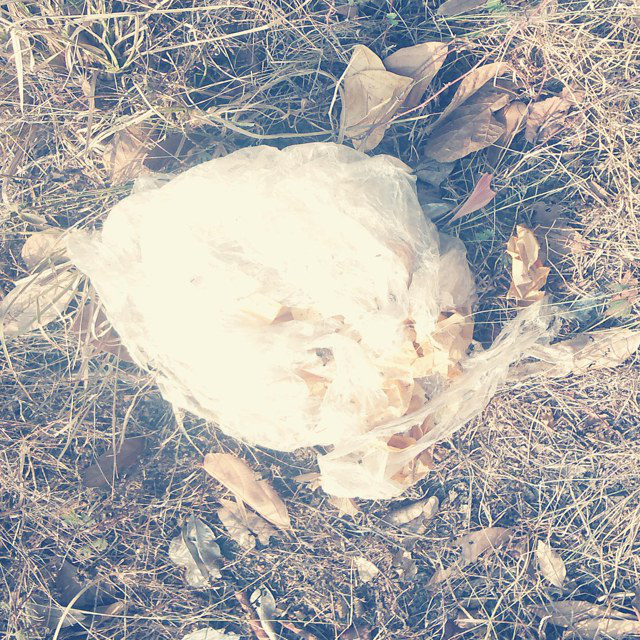

In [129]:
def simple_train_test_split(ids, test_ratio=0.15, seed=23):
    """simple train test split"""
    test_size = int(len(ids) * test_ratio)
    numpy_ids = np.array(ids)
    np.random.seed(seed)
    id_arr = np.array(range(len(ids)))
    np.random.shuffle(id_arr)
    print(numpy_ids.size, id_arr[test_size:].size)
    test, train = numpy_ids[id_arr[:test_size]], numpy_ids[id_arr[test_size:]]
    return train.tolist(), test.tolist()


def compl_train_test_split(a_file, test_ratio=0.21):
    """complex train test split"""
    d, ids, ds = remove_21_annotations(TACO_PATH + a_file, DEL1 + TO_REMOVE, [])
    annots = get_many_annotations(d)
    train1_ids, tst1_ids = simple_train_test_split([i for i in ids if len(annots[i]) == 1], test_ratio=test_ratio)
    train2_ids, tst2_ids = simple_train_test_split([i for i in ids if len(annots[i]) == 2], test_ratio=test_ratio)
    train3_ids, tst3_ids = simple_train_test_split([i for i in ids if len(annots[i]) > 2], test_ratio=test_ratio)
    return (train1_ids + train2_ids + train3_ids), (tst1_ids + tst2_ids + tst3_ids)


def merge_train_annotations(dsj1, dsj2):
    im_list = dsj1['images'] + dsj2['images']
    aa_list = dsj1['annotations'] + dsj2['annotations']
    sc_list = dsj1['scene_annotations'] + dsj2['scene_annotations']
    dsj1['images'] = im_list
    dsj1['annotations'] = aa_list
    dsj1['scene_annotations'] = sc_list
    return dsj1


def remove_bad_files(dsj):
    del1 = "BTl_001823_0.jpg"
    del2 = "large/unofficial"
    n = len(dsj['images'] )
    lst = [i for i in range(n) if dsj['images'][i]['file_name'].startswith(del2) or dsj['images'][i]['file_name'].endswith(del1)]
    print(lst)
    return lst
# dsj5, val_ids, dids = remove_21_annotations(TACO_PATH + 'annotations_unofficial.json', DEL1 + TO_REMOVE, [])
# val_ids = list(val_ids)
# train_aids, test_aids = simple_train_test_split(val_ids)
# print(len(train_aids))
# #bounding_boxes = adjust_boxes(np.array(boxes), np.array([[640 / w, 480 / h, 640 / w, 480 / h]]), 0, 0)
# TACO_PATH_U = '/media/pavel/42ca91cf-49ea-4c2e-9041-f23b53ddd153/srv/tmp/0/0litter/taco/taco/data/unofficial/'
# TACO_PATH_1 = '/media/pavel/42ca91cf-49ea-4c2e-9041-f23b53ddd153/srv/tmp/0/0litter/taco/taco/data/1/'
# # id_a, id_b = 4436, 7041
# # SPLIT = 'l'

# id1, id2 = id_a2, id_b2
# dsj2, id1, id2 = croping(train_aids, TACO_PATH, TACO_BATCH, 'annotations_unofficial.json',  id_a2, id_b2, single = True)

# dsj3, aid1, aid2 = croping(test_aids, TACO_PATH, TACO_BATCH, 'annotations_unofficial.json',  id1, id2, single = True)

# new_dsj1 = merge_train_annotations(new_dsj1, dsj2) 
# save_json_data(new_dsj1, os.path.join(TACO_PATH, 'annotations_6K.json'))
    
# new_dsj2 = merge_train_annotations(new_dsj2, dsj3)
# save_json_data(new_dsj2, os.path.join(TACO_PATH, 'annotations_2_K.json'))

# dsj, ids, ids_dont = remove_21_annotations(TACO_PATH + 'annotations_unofficial.json', TO_REMOVE, [])
# annots = get_many_annotations(dsj)
# images = dsj['images']
with open('train_aa.obj', 'wb') as f1:
    pickle.dump(new_dsj1, f1)
with open('test_aa.obj', 'wb') as f2:
    pickle.dump(new_dsj2, f2)
print(id1, id2, aid1, aid2)

# ii = new_dsj1['images']
# annots = get_many_annotations(new_dsj1)
# print(annots[ii[111]['id']])
# lst2 = [im['flickr_640_url'] for im in images if im['flickr_640_url'] is not None]
# print(len(lst2), len(set(lst2)))
# lst = [im['flickr_url'] for im in images if im['flickr_url'] is not None]
# print(len(lst), len(set(lst)))
# print(set(lst).intersection(set(lst2)))
# print(images)    

Image.open(TACO_PATH+new_dsj1['images'][999]['file_name']).show()

In [ ]:
pngs = [str(f)[(str(f).rfind("/")+1):] for f in Path("/media/pavel/tmp/unoff/").rglob("*.png")]
jpegs = [str(f)[(str(f).rfind("/")+1):] for f in Path("/media/pavel/tmp/unoff/").rglob("*.jpeg")]

def copy_image(input_dir, out_dir):
    """ change image type to jpg and save image """
    out_name = out_dir[(out_dir.rfind("/") + 1):]
    for_rotation = ["0001685.jpg", "0001397.jpg", "0001211.jpg",
                   "0001218.jpg", "0001021.jpg", "0000833.jpg",
                   "000241.jpg", "000334.jpg","000634.jpg"] # "000047.jpg", 
    image = Image.open(input_dir)
    or_exif = image._getexif()
    if or_exif:
        exif = dict(or_exif.items())
        #274 is the orientation tag code
        if 274 in exif:
            if exif[274] == 3:
                image = image.transpose(Image.ROTATE_180)
                or_exif[274] = 0
            if exif[274] == 6:
                image = image.transpose(Image.ROTATE_270)
                or_exif[274] = 0
            if exif[274] == 8:
                image = image.transpose(Image.ROTATE_90)
                or_exif[274] = 0
    if out_dir.rfind("0001685.jpg") > 1 or out_dir.rfind("0001397.jpg") > 1 or out_dir.rfind("0001211.jpg") > 1 
    or out_dir.rfind("0001218.jpg") > 1 or out_dir.rfind("0001021.jpg") > 1 or out_dir.rfind("0000833.jpg") > 1 
    or out_dir.rfind("000047.jpg") > 1 or out_dir.rfind("unofficial/00241.jpg") > 1 
    or out_dir.rfind("unofficial/00334.jpg") > 1  or out_dir.rfind("unofficial/00634.jpg") > 1:
        print("change image type 47")
        image = image.transpose(Image.ROTATE_90)    

    image.save(out_dir, quality=79)
    image.close()
    return

def convert_taco():
    """ copy 3500 taco pictures """
    NEW_PATH = "/home/pavel/TACO/data/"
    HOME = "/media/pavel/tmp/"
    TACO_UNO = "/media/pavel/tmp/unoff/"
    dsj = load_ds(path = NEW_PATH, name = 'annotations_unofficial.json')
    fnames = [im['file_name'] for im in dsj['images']]
    urls = [im['flickr_url'] for im in dsj['images']]
    files = [url[(url.rfind('/')+1):] for url in urls]

    print(pngs[:5])
    print(fnames[:3], urls[:3])
    for i in range(len(files)):
        name = files[i]
        if name in jpegs or name in pngs:
            try:
                copy_image(TACO_UNO + name, HOME + fnames[i])
            except OSError as e:
                print(f"IMAGE file is truncated {name}")
    return

NEW_PATH = "/home/pavel/TACO/data/"
HOME = "/media/pavel/tmp/"
TACO_UNO = "/media/pavel/tmp/unoff/"


def create_new_annotations(next_id, annots_id, dsj, image, annotations, scene):
    last_aid = annots_id
    last_id = next_id
    lid = [images]

    last_id += 1
    image_data = deepcopy(image)
    image_data['id'] = last_id
    dsj['images'].append(image_data)
    if scene is not None:
        sc = deepcopy(scene)
        sc['image_id'] = last_id
        dsj['scene_annotations'].append(sc)

    for a in annotations:
        last_aid += 1
        annots = deepcopy(a)          
        annots['id'] = last_aid
        annots['image_id'] = last_id
        dsj['annotations'].append(annots)
    return last_id, last_aid


def add_all_annotations(ids, images, annotations, scenes_dict, out_dir):
    new_dsj = load_ds()
    max_id = get_max_imageid(new_dsj['images'])
    max_aid = get_max_annotation_id(new_dsj['annotations'])
    for img in images:
        if img['id'] in ids:
            annots = annotations[img['id']]
            scene = scenes_dict[img['id']] if img['id'] in scenes_dict else None
            if len(annots) == 0:
                continue
            print(img['file_name'], len(annots))
            max_id, max_aid = create_new_annotations(max_id, max_aid, new_dsj, img, annots, scene)
    return new_dsj

# dsj, ids_rotate, ids_dont = remove_21_annotations(TACO_PATH + 'annotations.json', TO_REMOVE, do_not_rotate)
# my_dsj = load_ds(path = NEW_PATH, name = 'annotations_unofficial.json')
# annotations = get_many_annotations(my_dsj)
# scenes = {sc['image_id']:sc for sc in my_dsj['scene_annotations']}
# print(annotations[0])
# jsn = add_all_annotations(my_ids, my_dsj['images'], annotations, scenes, TACO_PATH + 'annotations_unofficial.json')

# save_json_data(jsn, os.path.join(TACO_PATH, 'new_un_annotations.json'))

convert_taco()

In [ ]:
print(fnames)
# dsj, ids_rotate, ids_dont = remove_21_annotations(TACO_PATH, TO_REMOVE, do_not_rotate)
# annotations = get_many_annotations(dsj)
# images = {c['id']:c for c in dsj['images']}
# sample = 'batch_5/000103.JPG'
# id_ = 0
# for img in dsj['images']:
#     if (img['file_name'] == sample):
#         id_ = img['id']
#         print(img['id']); break
# w, h = images[id_]['width'], images[id_]['height']
# categs = [a['category_id'] for a in annotations[id_]]
# boxes = [a['bbox'] for a in annotations[id_]]
# bb1 = boxes[0]
# bb2 = boxes[1]
# print(boxes)

# cnt = 0
# STAT=[]
# ctx = Context()
# for img in images.values():
#     if img['id'] in ids_rotate:
#         id_ = img['id']
#         annots=annotations[img['id']]
#         if len(annots) < 4:
#             continue
#         print("id/path/annotations: ", img['file_name'], len(annots))
#         ctx.request(MultipleItemsGenerator).generate_samples(id_, images, annotations, 
#                                                                    TACO_PATH, TACO_CROPS)
#         cnt += 1
#         if cnt == 255:
#             break


In [ ]:
def remove_img(dsj, to_remove):
    remove_lower_case = [p.lower for p in to_remove]
    result = [img for img in dsj['images'] if img['file_name'].lower() not in remove_lower_case]
    return result, [img['id'] for img in result]

def remove_annotations(dsj, ids):
    return [a for a in dsj['annotations'] if i not in ids]
          
data = {}   
raw_data = json.dumps(data)
        
#images: 'id': 0, 'width': 1537, 'height': 2049, 'file_name': 'batch_1/000006.jpg'
#annotations: 'id': 1, 'image_id': 0, 'category_id': 6, 'segmentation'
xy = np.array([1.,2.,300.,300.])
xy_t = np.array([5.,6.])
xy2 = np.array([3.,4.])
xy2_t = np.array([7.,8.])
a = np.array([xy, xy_t])
print(a,a[0])
print(xy.prod(axis=0))

tl_intersect = np.max(np.array([xy_t, xy_t]), axis=0)
tl_intersect.astype(float)
br_intersect = np.min(np.array([xy2, xy2_t]), axis=0)
# gt box and pred box intersection
is_intersect = (tl_intersect < br_intersect).astype(int).prod(axis=0)
is_intersect
print(xy2.shape[0], len(xy2))

#iou_dist(xy, xy, 3000, 3000)
xy2.tolist()

In [ ]:
boxes = [[0.,11.,21.,31.],[2.,4.,6.,8.]]
rats = [[.5,.4,.3,.2]]
categories = [1,2,3,4,5]
list(zip(boxes, categories))
lst = [[], [1], [1,2,3]]
sorted(lst, key=lambda x: len(x), reverse=True)
b = np.array(boxes)
r = np.array(rats)
print(b*r)

In [ ]:
counts = 33
total_count = 44
msg = f"Общее количество машин на фото {total_count} (Всего автомобилей {counts}, \
        всего автобусов)"
msg

In [ ]:
dsj, ids_rotate, ids_dont = remove_21_annotations(TACO_PATH, TO_REMOVE, do_not_rotate)
lst = list(ids_rotate) + list(ids_dont)
print(len(lst), len(ids))

In [ ]:
print(set([1,2,3]).union(set([3,7,1])))

In [28]:
# ann_filepath = os.path.join("/media/pavel/11b20043-29ef-495b-a4d6-9e65e8a48f8b/srv/tmp/0/0litter/taco/taco/data" , 'annotations.json')
# with open(ann_filepath, 'r') as f:
#     ds = json.load(f)
# #print(ds['images']);
# im_files = {c['id']:c for c in ds['images']}
#print(im_files); 
# print(ds['annotations'])
np.abs(4.-5.5)

1.5

In [52]:

def copy_image_180(input_dir, out_dir):
    """ change image type to jpg and save image """
    out_name = out_dir[(out_dir.rfind("/") + 1):]
    image = Image.open(input_dir)
    image = image.transpose(Image.ROTATE_180)
    image.save(out_dir, quality=79)
    image.close()
    return

def copy_image_270(input_dir, out_dir):
    """ change image type to jpg and save image """
    out_name = out_dir[(out_dir.rfind("/") + 1):]
    image = Image.open(input_dir)
    image = image.transpose(Image.ROTATE_270)
    image.save(out_dir, quality=79)
    image.close()
    return

rotate180 = [
"000042.jpg",
"000056.jpg",
"000636.jpg",
"001594.jpg",
"002231.jpg",
"002436.jpg",
"003419.jpg",    
]
rotate270 = [    
"001685.jpg",
"001211.jpg",
"001218.jpg",
"001021.jpg",
"000020.jpg",
"000039.jpg",
"000200.jpg",
"000216.jpg",
"000234.jpg",
"000241.jpg",
"000334.jpg",
"000336.jpg",
"000407.jpg",
"000419.jpg",
"000420.jpg",
"000427.jpg",
"000445.jpg",
"000454.jpg",
"000539.jpg",
"000595.jpg",
"000605.jpg",
"000609.jpg",
"000615.jpg",
"000634.jpg",
"000677.jpg",
"000690.jpg",
"000717.jpg",
"000734.jpg",
"000767.jpg",
"000830.jpg",
"000833.jpg",
"000889.jpg",
"000929.jpg",
"000987.jpg",
"001032.jpg",
"001121.jpg",
"001150.jpg",
"001245.jpg",
"001256.jpg",
"001339.jpg",
"001343.jpg",
"001363.jpg",
"001397.jpg",
"001438.jpg",
"001492.jpg",
"001496.jpg",
"001524.jpg",
"001590.jpg",
"001661.jpg",
"001703.jpg",
"001733.jpg",
"001827.jpg",
"001843.jpg",
"001860.jpg",
"001866.jpg",
"001884.jpg",
"001905.jpg",
"001925.jpg",
"001947.jpg",
"001977.jpg",
"002034.jpg",
"002064.jpg",
"002091.jpg",
"002092.jpg",
"002104.jpg",
"002127.jpg",
"002132.jpg",
"002244.jpg",
"002332.jpg",
"002371.jpg",
"002392.jpg",
"002421.jpg",
"002449.jpg",
"002482.jpg",
"002537.jpg",
"002561.jpg",
"002604.jpg",
"002620.jpg",
"002647.jpg",
"002652.jpg",
"002687.jpg",
"002752.jpg",
"002765.jpg",
"002949.jpg",
"003000.jpg",
"003018.jpg",
"003046.jpg",
"003089.jpg",
"003091.jpg",
"003203.jpg",
"003216.jpg",
"003217.jpg",
"003238.jpg",
"003241.jpg",
"003246.jpg",
"003249.jpg",
"003319.jpg",
"003340.jpg",
"003342.jpg",
"003357.jpg",
"003462.jpg",
"003471.jpg",
"003510.jpg",
"003511.jpg",
"003529.jpg",
]


np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [91]:
numpy_ids = np.array([0,1,2,3,4,5,6])
test_size = 2
np.random.seed(1)
id_arr = np.array(range(7))
np.random.shuffle(id_arr)
test, train = numpy_ids[id_arr[:test_size]], numpy_ids[id_arr[test_size:]]
print(id_arr, train.tolist(), test.tolist())

[6 2 1 0 4 3 5] [1, 0, 4, 3, 5] [6, 2]


In [97]:
numpy_ids = np.array([0,1,2,3,4,5,6])
np.array(numpy_ids).size

7

In [15]:
import pickle
import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from torchvision import transforms
from torchvision.models import resnet18
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn import Dropout
from torch.nn import Conv1d
from torch.nn import BatchNorm1d
from torch.nn import BatchNorm2d
import torch.nn as nn
import torch
import torchvision
import os, shutil, glob

In [ ]:
np.hstack()

In [12]:
a = [1,2,4,5,6]
list(reversed(a))

[6, 5, 4, 2, 1]